<a href="https://colab.research.google.com/github/stefanlessmann/VHB_ProDoc_ML/blob/master/ProDok_ML_PreCourse_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Distinguishing borrowers into good and bad credit risks
In our second task, we continue working on binary classification using  logistic regression. However, instead of synthetic toy data, we will use a real world-data set referring to risk management and decision-making in credit scoring. Compared to our first task, this classification problem is much harder to solve and requires a number of steps to get a good result. The following tasks will guide you through the process of loading, integrating, and preparing the data to eventually develop a logistic regression model. The final model predicts the probability of a credit applicant to default, meaning that the outstanding amount would not be paid back (in full). If you would like some  background information on retail credit risk assessment, have a look at our paper on[ benchmarking classification models for credit scoring](https://doi.org/10.1016/j.ejor.2015.05.030).

Should you feel that logistic regression is a rather simple model for a machine learning course, I can assure you that we will look at several more advanced learning algorithms in the course and apply some of these to the same credit scoring data you are about to use. That said, note that logistic regression is the single most important model for loan approval decisions in the industry. Familiarity with logistic regression is crucial for every data scientists and  machine learners. 

Also note that the focus of the task is not on developing a highly accurate classifier. This will soon become our goal but first we need to do some homework: **data preparation**. Data preparation is the core of the task. The data set is challenging and you need to work hard to bring the data into a form that facilitates building classification models. In the scope of doing so, you will work intensively with Python libraries commonly used in machine learning such as Pandas. Becoming acquainted with these libraries and gaining experience in working with complex, messy real-world data is the core of the task. 

So let's being with loading some of these standard libraries.

In [98]:
# Loading some libraries we will need soon
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)
pd.options.display.max_columns = 300
pd.options.display.max_rows = 50

We are ready to start working with the data that we obtained from Kaggle. As has probably become clear already, the following tasks are nontrivial and might challenge you quite a bit. Work hard to solve them. It is definitly possible. Since the data is wel-known, you can also find much information and tips online, e.g., in the forum of the [Kaggle competition](https://www.kaggle.com/discussion). Shoud you nonetheless struggle with getting the data ready for analysis, using a shortcut is better than giving up. Much of the complexity of the following tasks comes from us integrating different sources of data. Getting the data ready for analysis would be a lot easier when using only the single data file *application_train.csv*. Using only this file, you could still perform many of the tasks we discuss below including handling missing values and outliers, scaling numeric variables, encoding categories, and, of course, developing a logistic regression classifier. 

## Create the initial dataset
We will consider a subset of the available data from the [Kaggle Home credit default risk competition](https://www.kaggle.com/c/home-credit-default-risk/data):
- application_train
- application_test
- bureau
- previous_application

The terms *training* and *test* data are omnipresent in (supervised) machine learning. We use the training data to build a model and the test data to assess that model. Importantly, the assessment involves applying the fully-specified (i.e., train**ed**) model to data that was not used before during model development (i.e., train**ing**). Another, more technical, important difference between the train and test data is that the former provides true labels for observations (i.e., a binary default / no-default indicator) whereas the latter does not. By observations we mean the rows of a DATA table, which correspond to bank clients who apply for a loan in the home credit data set.

First of all, we are required to load the pre-processed h5 file as well as the datasets it contains. This requires you to have executed the data integration notebook for the home credit data and that the h5 file is available. Should that not be the case make sure to run the data integration notebook before moving on.


We will now merge both train and test data with the other two datasets. First load the four above data sets into different pandas data frames using the *read_hdf* function. 

In [641]:
# Here is your first job: 
# Load the following data sets from the file data.h5, which you created when
# executing the data integration notebook. Create one dataframe for each data 
# set. 
#   application_train (appl_train)
#   application_test (appl_test)
#   bureau (bureau)
#   previous_application (prev)
# where the entries in brackets suggests names for the corresponding variables.
appl_train = pd.read_hdf("data.h5", key = "appl_train")
appl_test  = pd.read_hdf("data.h5", key = "appl_test")
bureau     = pd.read_hdf("data.h5", key = "bureau")
prev       = pd.read_hdf("data.h5", key = "prev")

Well done!

I know that the task to load some data seems rather trivial. However, especially when working with colab, some seemingly rudimentary tasks are not so easy and probably new to participants who have not used cloud-based services before. Hence, good you made it till here!

You may have wondered why we have to bother with four different files at all. Well, companies routinely store data in databases and these consist of individual tables. The organization of the data at Kaggle mimics this approach. Different pieces of information are available in different tables, which can be linked to one another via shared columns (called foreign keys in database jargon). 

### Integrating the data
Our next task is to merge the data set to create one big table. To that end, you first have to identify suitable key columns, which facilitate joining the different data sets. Note that the data set [homepage](https://www.kaggle.com/c/home-credit-default-risk/data) offers a nice graph of the structure of the data. Considering that graph, identifying suitable keys should not be that difficult. Once accomplished, the missing bit is a suitable function to merge data frames. A good time to ask your favorite search engine for help ;)

In [642]:
appl_train.head()

,SK_ID_CURR,TARGET,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_CODE_GENDER,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EMERGENCYSTATE_MODE,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_NAME_CONTRACT_TYPE,app_NAME_EDUCATION_TYPE,app_NAME_HOUSING_TYPE,app_NAME_INCOME_TYPE,app_OCCUPATION_TYPE,app_ORGANIZATION_TYPE,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY
0,100002,1,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2
1,100003,0,-16765,35698.5,1293502.5,1129500.0,270000.0,F,-291,-828.0,-1186.0,No,0.311267,0.622246,NaN,1,0,-1188,Cash loans,Higher education,House / apartment,State servant,Core staff,School,0,1,1
2,100004,0,-19046,6750.0,135000.0,135000.0,67500.0,M,-2531,-815.0,-4260.0,NaN,NaN,0.555912,0.729567,1,1,-225,Revolving loans,Secondary / secondary special,House / apartment,Working,Laborers,Government,0,2,2
3,100006,0,-19005,29686.5,312682.5,297000.0,135000.0,F,-2437,-617.0,-9833.0,NaN,NaN,0.650442,NaN,1,0,-3039,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2
4,100007,0,-19932,21865.5,513000.0,513000.0,121500.0,M,-3458,-1106.0,-4311.0,NaN,NaN,0.322738,NaN,1,0,-3038,Cash loans,Secondary / secondary special,House / apartment,Working,Core staff,Religion,1,2,2


In [643]:
bureau.head()

,SK_ID_CURR,bur_SK_ID_BUREAU,bur_CREDIT_ACTIVE,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_CREDIT_TYPE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,NaN,0,0.0,NaN,0.0,Consumer credit,-497,-153.0,-131
1,215354,5714463,Active,NaN,0,171342.0,NaN,0.0,Credit card,-208,1075.0,-20
2,215354,5714464,Active,NaN,0,NaN,NaN,0.0,Consumer credit,-203,528.0,-16
3,215354,5714465,Active,NaN,0,NaN,NaN,0.0,Credit card,-203,NaN,-16
4,215354,5714466,Active,NaN,0,NaN,NaN,0.0,Consumer credit,-629,1197.0,-21


In [644]:
prev.head()

,SK_ID_CURR,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CHANNEL_TYPE,pre_CNT_PAYMENT,pre_CODE_REJECT_REASON,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_NAME_CASH_LOAN_PURPOSE,pre_NAME_CLIENT_TYPE,pre_NAME_CONTRACT_STATUS,pre_NAME_CONTRACT_TYPE,pre_NAME_GOODS_CATEGORY,pre_NAME_PAYMENT_TYPE,pre_NAME_PORTFOLIO,pre_NAME_PRODUCT_TYPE,pre_NAME_SELLER_INDUSTRY,pre_NAME_TYPE_SUITE,pre_NAME_YIELD_GROUP,pre_PRODUCT_COMBINATION,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA
0,271877,2030495,1730.430054,17145.0,17145.0,0.0,17145.0,Country-wide,12.0,XAP,-73,-42.0,-42.0,-37.0,15,XAP,Repeater,Approved,Consumer loans,Mobile,Cash through the bank,POS,XNA,Connectivity,NaN,middle,POS mobile with interest,0.0,0.867336,35
1,108129,2802425,25188.615234,607500.0,679671.0,NaN,607500.0,Contact center,36.0,XAP,-164,-134.0,365243.0,365243.0,11,XNA,Repeater,Approved,Cash loans,XNA,XNA,Cash,x-sell,XNA,Unaccompanied,low_action,Cash X-Sell: low,NaN,NaN,-1
2,122040,2523466,15060.735352,112500.0,136444.5,NaN,112500.0,Credit and cash offices,12.0,XAP,-301,-271.0,365243.0,365243.0,11,XNA,Repeater,Approved,Cash loans,XNA,Cash through the bank,Cash,x-sell,XNA,"Spouse, partner",high,Cash X-Sell: high,NaN,NaN,-1
3,176158,2819243,47041.335938,450000.0,470790.0,NaN,450000.0,Credit and cash offices,12.0,XAP,-512,-482.0,-182.0,-177.0,7,XNA,Repeater,Approved,Cash loans,XNA,Cash through the bank,Cash,x-sell,XNA,NaN,middle,Cash X-Sell: middle,NaN,NaN,-1
4,202054,1784265,31924.394531,337500.0,404055.0,NaN,337500.0,Credit and cash offices,24.0,HC,-781,NaN,NaN,NaN,9,Repairs,Repeater,Refused,Cash loans,XNA,Cash through the bank,Cash,walk-in,XNA,NaN,high,Cash Street: high,NaN,NaN,-1


In [645]:
bureau.shape

(1716428, 12)

In [646]:
# Merge the data on previous applications (prev) into the training data (appl_train)
# and also into the test data (appl_test)
train = appl_train.merge (prev, how = "left", on = "SK_ID_CURR")
test  = appl_test.merge (prev, how = "left", on = "SK_ID_CURR")

In [647]:
train.shape

(1430155, 56)

In [648]:
# Next merge the credit bureau data into the training and test set.
train = train.merge (bureau, how = "left", on = "SK_ID_CURR")
test  = test.merge (bureau, how = "left", on = "SK_ID_CURR")

In [649]:
train.shape

(8091522, 67)

In [650]:
test.shape

(1582679, 66)


Note that the above operation of merging the data is equivalent to a join operation in SQL. Did you now that SQL knows different ways to join tables? Check which type of join you have performed, left, right, or inner. And then ask yourself what type would the correct for our data.

At this point, you should have two dataframes that store the training and test data, respectively. Run the following code cell to get an overview of all variables in your workspace. Also add code to display the dimensionality of your data, that is the number of rows and columns. Do this for the training and test set.

In [12]:
# Run this to get an overview of variables in your workspace
%whos

# Write some code to query the dimensionality of your dataframes. 
# Put differently, how many rows and columns are available in the 
# training and test set?
print('\nDimension of the training and test set:')
print(train.shape)
print(test.shape)

Variable     Type         Data/Info
-----------------------------------
appl_test    DataFrame    <object with id 4663812176 (str() failed)>
appl_train   DataFrame    <object with id 4663427664 (str() failed)>
bureau       DataFrame    <object with id 4664020624 (str() failed)>
gc           module       <module 'gc' (built-in)>
np           module       <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
pd           module       <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
plt          module       <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
prev         DataFrame    <object with id 4695478928 (str() failed)>
test         DataFrame    <object with id 4663398608 (str() failed)>
train        DataFrame    <object with id 4354434192 (str() failed)>

Dimension of the training and test set:
(8091522, 67)
(1582679, 66)


You should see a bit more than 8 mio. rows in the training set and about close to 1.6 mio. rows in the test set. That is a lot of data! Complete the following code cell to query the dimensionality of the original dataframes that you have loaded from data.h5

In [651]:
# Query dimensionality of the four dataframes 
# appl_train, appl_test, bureau, and prev.
print (appl_train.shape, " - Appl_train")
print (appl_test.shape, " - Appl_test")
print (bureau.shape, " - Bureau")
print (prev.shape, " - Prev")

(307511, 27)  - Appl_train
(48744, 26)  - Appl_test
(1716428, 12)  - Bureau
(1670214, 30)  - Prev


Hopefully the above task was easy for you. It actually produced an important result. See how the original data was much smaller. For example, you should see 307511 observations in *application_train*. However, the number of observations in the dataframe *train*, which you created by merging the application, bureau, and previous applications data, was much larger; i.e., about 8 mio. Why is that?

### Understanding data integration
The answer is related to the way in which dataframes (tables) are merged (joined). I encourage you to spend some time on this matter to understand how we ended up with more than 8 mio. rows in the training data. Eyballing the data using the Pandas function *head() is a good starting point.  

In [652]:
# Use the function head() to get on overview of the training data after merging
train.head()

,SK_ID_CURR,TARGET,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_CODE_GENDER,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EMERGENCYSTATE_MODE,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_NAME_CONTRACT_TYPE,app_NAME_EDUCATION_TYPE,app_NAME_HOUSING_TYPE,app_NAME_INCOME_TYPE,app_OCCUPATION_TYPE,app_ORGANIZATION_TYPE,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CHANNEL_TYPE,pre_CNT_PAYMENT,pre_CODE_REJECT_REASON,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_NAME_CASH_LOAN_PURPOSE,pre_NAME_CLIENT_TYPE,pre_NAME_CONTRACT_STATUS,pre_NAME_CONTRACT_TYPE,pre_NAME_GOODS_CATEGORY,pre_NAME_PAYMENT_TYPE,pre_NAME_PORTFOLIO,pre_NAME_PRODUCT_TYPE,pre_NAME_SELLER_INDUSTRY,pre_NAME_TYPE_SUITE,pre_NAME_YIELD_GROUP,pre_PRODUCT_COMBINATION,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_CREDIT_ACTIVE,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_CREDIT_TYPE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE
0,100002,1,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158904.0,Closed,0.0,0.0,NaN,NaN,0.0,Credit card,-1125.0,-1038.0,-1038.0
1,100002,1,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158905.0,Closed,NaN,0.0,0.0,NaN,0.0,Credit card,-476.0,NaN,-47.0
2,100002,1,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158906.0,Closed,0.0,0.0,0.0,0.0,0.0,Consumer credit,-1437.0,-1072.0,-1185.0
3,100002,1,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158907.0,Closed,0.0,0.0,NaN,NaN,0.0,Consumer credit,-1121.0,-911.0,-906.0
4,100002,1,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158908.0,Closed,0.0,0.0,0.0,0.0,0.0,Consumer credit,-645.0,85.0,-34.0


You should have seen a pattern that one credit applications, with a given ID, re-appears. Noting this pattern is the starting point to explaining the difference between 307511 credit applications in the training set (indeed, we do only have that many applications) and the more than 8 mio. observations we obtain after merging. Merging reproduces rows. 

Imagine a single credit applicant. Let's call her Eve. Eve applies for a loan. We would see one entry for Eve in the original training data (application_train at the Kaggle website). The data file previous_applications provides information about the credit history of Eve. Let's assume she had applied for ten different loans in the past. So the previous_applications file has ten entries for Eve. Merging application_train and previous_applications, we obtain ten entries for Eve in the resulting dataframe. The values for the variables (i.e., columns) of the application data re-occur over these ten rows, whereas the values in the columns belonging to the previous application data will vary. In the above sketch of the data, you can scroll to the right to verify that such a pattern exist. A first block of colums displays re-occuring values. Later on, there is a block of columns the values of which do not re-occur.

I recommend you go back to previous steps, re-run cells, maybe playing a bit with the *head()* function, etc. to make sure you fully understand what has happend with the data before moving on. 

### Moving on
Maybe it is time to clean up a little bit. Since you have the training and test data integrated, you do not need the dataframes that you created when loading the data from disk. Delete these and other unneeded variables from memory. This is important to avoid your notebook chrashing because of out of memory errors. Remeber, the training and test set have, togehter, close to 10 mio. observations. We better pay attention to how much memory or program consumes. 

In [653]:
del bureau, prev, appl_train, appl_test

Machine learning commonly involves processing *large* data sets. The previous steps gave us a feeling for such data. Subsequent steps will also exemplify some of the specific challanges that arise when working with larger data sets. What I mean by that? You should ready yourself for experiecing your notebook to crash due to out of memory errors and the like. Your will also notice that certain computations take a 'little' time to complete. Do not allow such issues to frustrate you should they occur. Using machine learning in your research will involve processing nontrivial data sets. So it is good to get familiar with somewhat complex data and the home credit data was deliberately chosen for that reason.

One idea to keep the level of frustration as low as possible. Whenever you have accomplised a task and created a new version of the data, you can store it to an h5 file. The data integration notebook has familiarized you with that operation. The benefit of storing intermediate results is that when your code crashes at some point, you can load the intermediate result (i.e., data) and re-start from there. This is easier compared to having to re-start from scratch every time.

## Explorative data analysis (EDA)

Finally, we are ready to start working with the data. As a rule of thumb, the first step is always to inspect the data and get a first impression.

Your job is to figure out which of the variables in the data set, in other words columns, might be important for classifying observations (aka rows, aka credit applications) into good and bad risks.  

In exploratory data analysis (EDA), as the name entails, we explore data - in particular by plotting the distribution of different variables or by looking at the correlation between variables.

First of all, take a look at the distribution of the target variable.

Then, take three variables from all three sources (application, bureau, previous_application). Create variable distribution and correlation plots to check whether the selected variables appear important. The packages matplotlib pyplot (already loaded) or alternatively seaborn will help you here.


### Application:

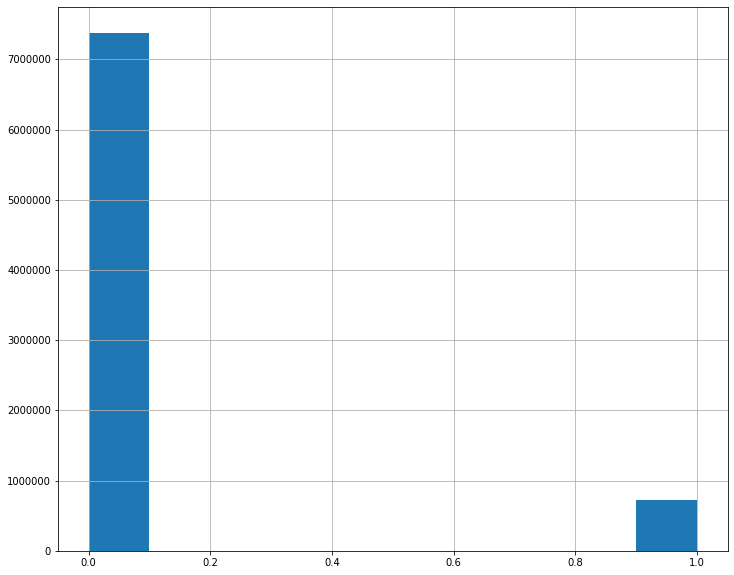

In [18]:
# Plot the distribution of the target variable
train.TARGET.hist(figsize = (12,10))

In [19]:
train.shape

(8091522, 67)

In [57]:
# Start out with a correlation plot -> strong correlation with the target variable 
# might be an indication that a variable is important. However, since there are 
# many variables in the data, I recommend you restrict the plot to a subset.
corr = train.corr()
corr.style.background_gradient(cmap = 'coolwarm').set_precision(3)

In [59]:
corr.TARGET.sort_values(ascending = False)

TARGET                             1.000000
bur_DAYS_CREDIT                    0.067819
app_DAYS_BIRTH                     0.064657
app_REGION_RATING_CLIENT_W_CITY    0.052328
app_REGION_RATING_CLIENT           0.051238
app_DAYS_LAST_PHONE_CHANGE         0.045816
app_DAYS_ID_PUBLISH                0.045232
bur_DAYS_CREDIT_UPDATE             0.045163
pre_CNT_PAYMENT                    0.044350
pre_DAYS_DECISION                  0.039655
app_REG_CITY_NOT_WORK_CITY         0.037440
app_FLAG_EMP_PHONE                 0.035920
app_DAYS_REGISTRATION              0.032477
bur_DAYS_CREDIT_ENDDATE            0.031295
pre_RATE_INTEREST_PRIVILEGED       0.029005
app_FLAG_WORK_PHONE                0.022024
pre_AMT_GOODS_PRICE                0.014224
pre_DAYS_LAST_DUE                  0.011936
pre_DAYS_TERMINATION               0.011760
pre_AMT_CREDIT                     0.008202
bur_AMT_CREDIT_SUM_OVERDUE         0.007705
bur_AMT_CREDIT_SUM_DEBT            0.007304
pre_AMT_APPLICATION             

In [955]:
import seaborn as sns

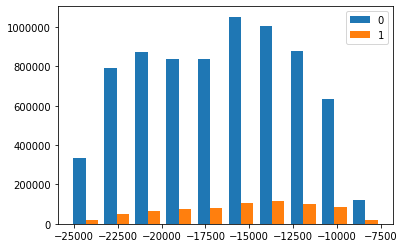

In [22]:
x1 = list(train[train['TARGET'] == 0]['app_DAYS_BIRTH'])
x2 = list(train[train['TARGET'] == 1]['app_DAYS_BIRTH'])

plt.hist([x1, x2], histtype='bar', label = [0, 1])
plt.xlabel = "DAYS_BIRTH"
plt.ylabel = "count"
plt.legend()

In [23]:
# Comparison is difficult when not using density plots / stratified plots considering the target variable.
# Out of the set of variables you consider above, select the one which is most 
# correlated with the target and visualize the variable's distribution for 
# good and bad credit applicants


Play around by running your code for other variables and examine their distribution across the two states of our target variable, good or bad, which are encoded as zero and one, respectively in the data. Make sure to also plot the distributions using both counts and relative frequencies.
Hint: check out the option *density=True*.
Finally, recall that we have previously merged different sources of data, application data, which consists of the information a credit applicant provides upon applying for a loan, bureau data, which is gathered by credit bureaus like the Schufa in Germany of Experian in the US, and data from previous credit applications of the same applicant. Make sure to examine variables (create plots) from each of these sources, and remember your focus: you strive to identify *important* variables. This is why your plots should display a variable's distributions for good and bad customers. 

In [24]:
# Code for exploring other variables goes here

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14d7bb590>,
      dtype=object)

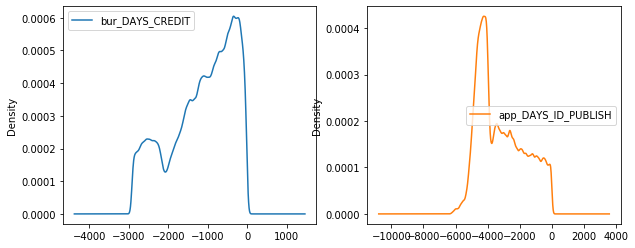

In [25]:
train[["bur_DAYS_CREDIT", "app_DAYS_ID_PUBLISH"]].plot(kind='density', subplots=True, layout=(1, 2), 
                  sharex=False, figsize=(10, 4))

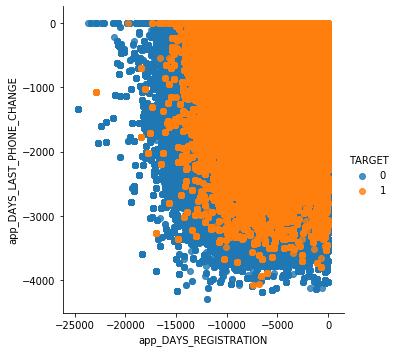

In [26]:
sns.lmplot('app_DAYS_REGISTRATION','app_DAYS_LAST_PHONE_CHANGE', data = train, hue = 'TARGET', fit_reg=False )

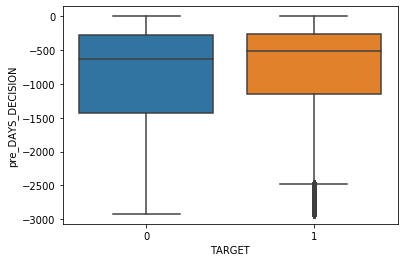

In [27]:
sns.boxplot(x = 'TARGET', y = 'pre_DAYS_DECISION', data = train)

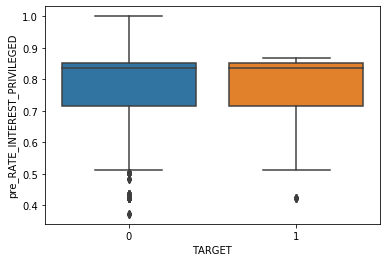

In [28]:
sns.boxplot(x = 'TARGET', y = 'pre_RATE_INTEREST_PRIVILEGED', data = train)

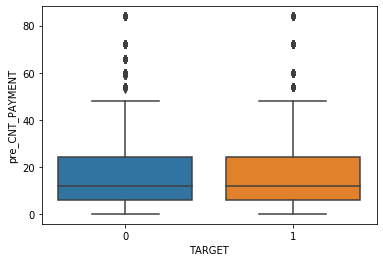

In [29]:
sns.boxplot(x = 'TARGET', y = 'pre_CNT_PAYMENT', data = train)

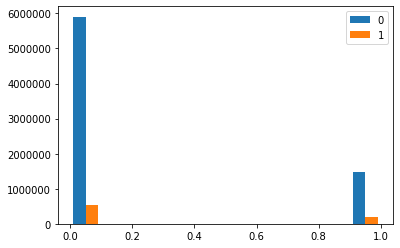

In [30]:
x1 = list(train[train['TARGET'] == 0]['app_REG_CITY_NOT_WORK_CITY'])
x2 = list(train[train['TARGET'] == 1]['app_REG_CITY_NOT_WORK_CITY'])

plt.hist([x1, x2], histtype='bar', label = [0, 1])
plt.xlabel = "City"
plt.ylabel = "count"
plt.legend()

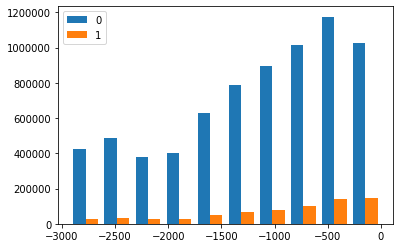

In [31]:
x1 = list(train[train['TARGET'] == 0]['bur_DAYS_CREDIT'])
x2 = list(train[train['TARGET'] == 1]['bur_DAYS_CREDIT'])

plt.hist([x1, x2], histtype='bar', label = [0, 1])
plt.xlabel = "Days"
plt.ylabel = "count"
plt.legend()

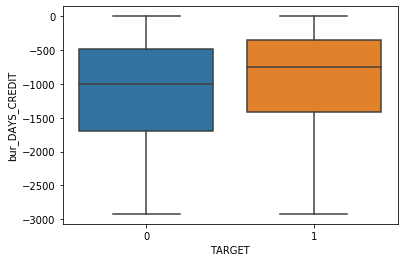

In [32]:
sns.boxplot(x = 'TARGET', y = 'bur_DAYS_CREDIT', data = train) 

Ok, that should be enough plotting for now. Did you produce any meaningful findings? Any clues which variables matter the most and which source of data is most relevant? Any evidence of outliers, data errors or the like? These are exemples of the type of questions EDA is meant to answer.

## Data preparation

Now that you have created the dataset and have a good understanding of it, it is time to prepare the data for the binary classification task. Likely, while trying to find relevant variables, you already noticed some issues with the data. In this sub-task, we will deal with those issues. First of all, we store the target variable of the train dataset in a separate dataframe and delete it from the train dataset. This allows us to combine the train and test dataframes, which, in turn, is useful because we want to apply operations such as imputing missing values or scaling the values of a variable to the training and the test data. 

In [654]:
train_new = train.copy()

In [655]:
# Extract the target variable from the training data and save it for later in a seperate dataframe
# Next, remove the target variable from the dataframe storing the training data
# Finally, create one large dataframe that stores both the training and test data
y = train_new.loc[: , [ "SK_ID_CURR", 'TARGET']]
train_new.drop('TARGET', axis = 1, inplace = True)

In [656]:
df = pd.concat([train_new, test])

In [657]:
y.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100002,1
2,100002,1
3,100002,1
4,100002,1


In [658]:
df.head()

,SK_ID_CURR,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_CODE_GENDER,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EMERGENCYSTATE_MODE,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_NAME_CONTRACT_TYPE,app_NAME_EDUCATION_TYPE,app_NAME_HOUSING_TYPE,app_NAME_INCOME_TYPE,app_OCCUPATION_TYPE,app_ORGANIZATION_TYPE,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CHANNEL_TYPE,pre_CNT_PAYMENT,pre_CODE_REJECT_REASON,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_NAME_CASH_LOAN_PURPOSE,pre_NAME_CLIENT_TYPE,pre_NAME_CONTRACT_STATUS,pre_NAME_CONTRACT_TYPE,pre_NAME_GOODS_CATEGORY,pre_NAME_PAYMENT_TYPE,pre_NAME_PORTFOLIO,pre_NAME_PRODUCT_TYPE,pre_NAME_SELLER_INDUSTRY,pre_NAME_TYPE_SUITE,pre_NAME_YIELD_GROUP,pre_PRODUCT_COMBINATION,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_CREDIT_ACTIVE,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_CREDIT_TYPE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE
0,100002,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158904.0,Closed,0.0,0.0,NaN,NaN,0.0,Credit card,-1125.0,-1038.0,-1038.0
1,100002,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158905.0,Closed,NaN,0.0,0.0,NaN,0.0,Credit card,-476.0,NaN,-47.0
2,100002,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158906.0,Closed,0.0,0.0,0.0,0.0,0.0,Consumer credit,-1437.0,-1072.0,-1185.0
3,100002,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158907.0,Closed,0.0,0.0,NaN,NaN,0.0,Consumer credit,-1121.0,-911.0,-906.0
4,100002,-9461,24700.5,406597.5,351000.0,202500.0,M,-2120,-1134.0,-3648.0,No,0.083037,0.262949,0.139376,1,0,-637,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,-606.0,-565.0,-25.0,-17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158908.0,Closed,0.0,0.0,0.0,0.0,0.0,Consumer credit,-645.0,85.0,-34.0


In [659]:
y.drop_duplicates( "SK_ID_CURR", keep = 'first',  inplace = True )

In [660]:
y.shape

(307511, 2)

By the way, before moving on, are you sure you solved the previous task? 

For those credit applicants that were part of the training set, you extracted the value of the target variable. Check. 

Then you added the data from the applicants that formed the test data to the training data. Check. 

So now you have one combined dataframe with all information on credit applicants (i.e., their variables) and another dataframe or vector that stores the target variable. 

Ok, sounds good. But to make sure your code is ready for subsequent tasks, check whether your solution would, in theory, allow you to revert these steps. You certainly remember our friend Eve. Eve was an applicant who appeared in the training data. We do know the true value of the target variable for Eve. After extracting the target variable from the training dataframe, would you still be able to tell the value of the target variable of Eve? And would you also be able to do so if we, for some reason, randomly permute the rows in the dataframe? 

If yes all is well. You can move on even if unsure but note that you may have to come back to the previous operation later and revisit the way in which you extracted the target variable from the training set.

One other point before moving on. How many observations (rows) do you have in the dataframe storing the target variable? We have 307511 credit applications in the training data so your answer should be 307511, right? I bet you get a different result when checking. What has happend and how can this be overcome? How to make sure that you have exactly 307511 values of the target varible? And are able to connect these values to the original credit applications? (Machine learners') Life is hard at times. 

### Time / Date based variables

Some variables in the data set represent time information, such as the age of a credit applicant (app_DAYS_BIRTH). Examine the way in which this information is stored. You could, for example, consider a histogram or simply check the value range of the variable. 

In [615]:
# Depict the distribution of the variable 'app_DAYS_BIRTH'

In [661]:
train_new.app_DAYS_BIRTH.nunique()

17460

In [662]:
train_new.app_DAYS_BIRTH.min(), train_new.app_DAYS_BIRTH.max()

(-25229, -7489)

You will have noticed that all entries for the variable are negative. It is common practice to store time-related information in such a way, e.g., the number of days that have past since some reference date. However, for data analysis, this format is less suitable. Your next task is to convert time information into a more useful format. This should be done for each variable that stores time related information. However, for simplicity we will only do the following:
1. Identify variables that store time information
1. Convert the values stored in those variables to positive numbers
1. Calculate the age of an applicant in years and store it in a new variable *app_AGE_YEARS* 

In [663]:
# Solutions to the three steps:
# 1. Determine relevant variables
date_columns = ['app_DAYS_BIRTH', 'app_DAYS_EMPLOYED', 
'app_DAYS_ID_PUBLISH', 
'app_DAYS_REGISTRATION',
'pre_DAYS_FIRST_DUE', 
'pre_DAYS_LAST_DUE', 
'pre_DAYS_TERMINATION', 
'bur_DAYS_CREDIT', 
'bur_DAYS_CREDIT_ENDDATE',
'bur_DAYS_CREDIT_UPDATE',
'app_DAYS_LAST_PHONE_CHANGE', 
'pre_DAYS_DECISION']

In [664]:
train_new['app_DAYS_EMPLOYED'] = train_new['app_DAYS_EMPLOYED'].apply(lambda x: np.nan if x > 0 else x)
test ['app_DAYS_EMPLOYED'] = test['app_DAYS_EMPLOYED'].apply(lambda x: np.nan if x > 0 else x)

In [665]:
train_new[train_new['app_DAYS_EMPLOYED'] < 0]['app_DAYS_EMPLOYED'].count()

6560655

In [666]:
train_new[date_columns].describe()

,app_DAYS_BIRTH,app_DAYS_EMPLOYED,app_DAYS_ID_PUBLISH,app_DAYS_REGISTRATION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_DAYS_LAST_PHONE_CHANGE,pre_DAYS_DECISION
count,8.091522e+06,6.560678e+06,8.091522e+06,8.091522e+06,4.649026e+06,4.649026e+06,4.649026e+06,7.916037e+06,7.408318e+06,7.916037e+06,8.091521e+06,8.027646e+06
mean,-1.654741e+04,-2.738823e+03,-3.162824e+03,-4.953579e+03,1.190623e+04,6.727679e+04,7.340619e+04,-1.140727e+03,4.887687e+02,-6.082592e+02,-1.154982e+03,-9.152466e+02
std,4.207643e+03,2.475571e+03,1.468020e+03,3.539191e+03,6.795989e+04,1.426775e+05,1.473811e+05,7.988853e+02,5.071592e+03,7.552931e+02,8.042227e+02,7.965792e+02
min,-2.522900e+04,-1.791200e+04,-7.197000e+03,-2.467200e+04,-2.892000e+03,-2.889000e+03,-2.874000e+03,-2.922000e+03,-4.206000e+04,-4.194700e+04,-4.292000e+03,-2.922000e+03
25%,-2.010300e+04,-3.648000e+03,-4.371000e+03,-7.449000e+03,-1.738000e+03,-1.428000e+03,-1.380000e+03,-1.668000e+03,-1.169000e+03,-9.130000e+02,-1.743000e+03,-1.401000e+03
50%,-1.622700e+04,-2.052000e+03,-3.509000e+03,-4.475000e+03,-9.060000e+02,-6.290000e+02,-5.850000e+02,-9.830000e+02,-3.590000e+02,-4.230000e+02,-1.156000e+03,-6.230000e+02
75%,-1.313000e+04,-9.650000e+02,-2.024000e+03,-1.939000e+03,-4.580000e+02,-1.340000e+02,-9.400000e+01,-4.650000e+02,4.380000e+02,-3.500000e+01,-4.540000e+02,-2.780000e+02
max,-7.489000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.652430e+05,3.652430e+05,3.652430e+05,0.000000e+00,3.119900e+04,3.720000e+02,0.000000e+00,-1.000000e+00


In [667]:
# 2. Convert all days_vars to positive numbers
train_new[date_columns] = train_new[date_columns].apply(np.abs)
test[date_columns] = test[date_columns].apply(np.abs)

In [668]:
train_new[date_columns].describe()

,app_DAYS_BIRTH,app_DAYS_EMPLOYED,app_DAYS_ID_PUBLISH,app_DAYS_REGISTRATION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_DAYS_LAST_PHONE_CHANGE,pre_DAYS_DECISION
count,8.091522e+06,6.560678e+06,8.091522e+06,8.091522e+06,4.649026e+06,4.649026e+06,4.649026e+06,7.916037e+06,7.408318e+06,7.916037e+06,8.091521e+06,8.027646e+06
mean,1.654741e+04,2.738823e+03,3.162824e+03,4.953579e+03,1.414977e+04,6.897043e+04,7.503399e+04,1.140727e+03,1.829234e+03,6.082600e+02,1.154982e+03,9.152466e+02
std,4.207643e+03,2.475571e+03,1.468020e+03,3.539191e+03,6.752842e+04,1.418665e+05,1.465591e+05,7.988853e+02,4.755402e+03,7.552924e+02,8.042227e+02,7.965792e+02
min,7.489000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.313000e+04,9.650000e+02,2.024000e+03,1.939000e+03,5.170000e+02,4.850000e+02,4.780000e+02,4.650000e+02,3.870000e+02,3.500000e+01,4.540000e+02,2.780000e+02
50%,1.622700e+04,2.052000e+03,3.509000e+03,4.475000e+03,9.930000e+02,1.171000e+03,1.186000e+03,9.830000e+02,8.700000e+02,4.230000e+02,1.156000e+03,6.230000e+02
75%,2.010300e+04,3.648000e+03,4.371000e+03,7.449000e+03,1.908000e+03,2.301000e+03,2.368000e+03,1.668000e+03,1.511000e+03,9.130000e+02,1.743000e+03,1.401000e+03
max,2.522900e+04,1.791200e+04,7.197000e+03,2.467200e+04,3.652430e+05,3.652430e+05,3.652430e+05,2.922000e+03,4.206000e+04,4.194700e+04,4.292000e+03,2.922000e+03


In [669]:
# 3. Calculate age of applicant (ignore leap years for simnplicity)
train_new['app_AGE_YEARS'] = train_new['app_DAYS_BIRTH'].apply(lambda x: round(x/365, 4) )
test['app_AGE_YEARS'] = test['app_DAYS_BIRTH'].apply(lambda x: round(x/365, 4) )

In [670]:
train_new.head()

,SK_ID_CURR,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_CODE_GENDER,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EMERGENCYSTATE_MODE,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_NAME_CONTRACT_TYPE,app_NAME_EDUCATION_TYPE,app_NAME_HOUSING_TYPE,app_NAME_INCOME_TYPE,app_OCCUPATION_TYPE,app_ORGANIZATION_TYPE,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CHANNEL_TYPE,pre_CNT_PAYMENT,pre_CODE_REJECT_REASON,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_NAME_CASH_LOAN_PURPOSE,pre_NAME_CLIENT_TYPE,pre_NAME_CONTRACT_STATUS,pre_NAME_CONTRACT_TYPE,pre_NAME_GOODS_CATEGORY,pre_NAME_PAYMENT_TYPE,pre_NAME_PORTFOLIO,pre_NAME_PRODUCT_TYPE,pre_NAME_SELLER_INDUSTRY,pre_NAME_TYPE_SUITE,pre_NAME_YIELD_GROUP,pre_PRODUCT_COMBINATION,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_CREDIT_ACTIVE,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_CREDIT_TYPE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS
0,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158904.0,Closed,0.0,0.0,NaN,NaN,0.0,Credit card,1125.0,1038.0,1038.0,25.9205
1,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158905.0,Closed,NaN,0.0,0.0,NaN,0.0,Credit card,476.0,NaN,47.0,25.9205
2,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158906.0,Closed,0.0,0.0,0.0,0.0,0.0,Consumer credit,1437.0,1072.0,1185.0,25.9205
3,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158907.0,Closed,0.0,0.0,NaN,NaN,0.0,Consumer credit,1121.0,911.0,906.0,25.9205
4,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158908.0,Closed,0.0,0.0,0.0,0.0,0.0,Consumer credit,645.0,85.0,34.0,25.9205


In [671]:
train_new.dtypes

SK_ID_CURR                    int32
app_DAYS_BIRTH                int32
app_AMT_ANNUITY             float32
app_AMT_CREDIT              float32
app_AMT_GOODS_PRICE         float32
                             ...   
bur_CREDIT_TYPE            category
bur_DAYS_CREDIT             float64
bur_DAYS_CREDIT_ENDDATE     float32
bur_DAYS_CREDIT_UPDATE      float64
app_AGE_YEARS               float64
Length: 67, dtype: object

### Numerical variables
Information is often stored as a numerical variable. The variables you processed above are an example. The age of an applicant is a numerical variable. Likewise, a credit score, an applicant's income, the amount of a loan, etc. are numerical variables.

Often, the scale of numerical variables varies substantially. A variable may also exhibit extreme values (i.e., outliers), which can cause problems. In this sub-task, you have to make choices concerning handling potential outliers.
Try to find all numerical variables and apply outlier detection. Box-Plots are always a helpful tool to check for outliers, however there might be other (more automatic) strategies to handle outliers.

The definition what value constitutes an outlier is somewhat subjective. Make a sensible decision and replace outliers by a missing-value.

In [672]:
numerics = train_new._get_numeric_data().columns

In [673]:
numerics

Index(['SK_ID_CURR', 'app_DAYS_BIRTH', 'app_AMT_ANNUITY', 'app_AMT_CREDIT',
       'app_AMT_GOODS_PRICE', 'app_AMT_INCOME_TOTAL', 'app_DAYS_ID_PUBLISH',
       'app_DAYS_LAST_PHONE_CHANGE', 'app_DAYS_REGISTRATION',
       'app_EXT_SOURCE_1', 'app_EXT_SOURCE_2', 'app_EXT_SOURCE_3',
       'app_FLAG_EMP_PHONE', 'app_FLAG_WORK_PHONE', 'app_DAYS_EMPLOYED',
       'app_REG_CITY_NOT_WORK_CITY', 'app_REGION_RATING_CLIENT',
       'app_REGION_RATING_CLIENT_W_CITY', 'pre_SK_ID_PREV', 'pre_AMT_ANNUITY',
       'pre_AMT_APPLICATION', 'pre_AMT_CREDIT', 'pre_AMT_DOWN_PAYMENT',
       'pre_AMT_GOODS_PRICE', 'pre_CNT_PAYMENT', 'pre_DAYS_DECISION',
       'pre_DAYS_FIRST_DUE', 'pre_DAYS_LAST_DUE', 'pre_DAYS_TERMINATION',
       'pre_HOUR_APPR_PROCESS_START', 'pre_RATE_DOWN_PAYMENT',
       'pre_RATE_INTEREST_PRIVILEGED', 'pre_SELLERPLACE_AREA',
       'bur_SK_ID_BUREAU', 'bur_AMT_ANNUITY', 'bur_CREDIT_DAY_OVERDUE',
       'bur_AMT_CREDIT_SUM_DEBT', 'bur_AMT_CREDIT_SUM_LIMIT',
       'bur_AMT_CREDIT_SU

In [674]:
numerics = list (set(numerics) - set(date_columns))

In [675]:
cols_to_del = ["app_FLAG_EMP_PHONE", "pre_SK_ID_PREV", "bur_SK_ID_BUREAU", "SK_ID_CURR", "pre_SK_ID_PREV", 
               'app_FLAG_WORK_PHONE', 'app_AGE_YEARS']
numerics = [num for num in numerics if num not in cols_to_del]

In [676]:
numerics.append('app_DAYS_EMPLOYED')
numerics

['pre_SELLERPLACE_AREA',
 'app_REG_CITY_NOT_WORK_CITY',
 'pre_AMT_DOWN_PAYMENT',
 'pre_HOUR_APPR_PROCESS_START',
 'app_REGION_RATING_CLIENT',
 'app_REGION_RATING_CLIENT_W_CITY',
 'pre_CNT_PAYMENT',
 'app_EXT_SOURCE_3',
 'app_EXT_SOURCE_2',
 'bur_CREDIT_DAY_OVERDUE',
 'pre_AMT_APPLICATION',
 'pre_RATE_DOWN_PAYMENT',
 'app_AMT_GOODS_PRICE',
 'pre_AMT_GOODS_PRICE',
 'bur_AMT_CREDIT_SUM_LIMIT',
 'app_AMT_ANNUITY',
 'bur_AMT_ANNUITY',
 'bur_AMT_CREDIT_SUM_OVERDUE',
 'app_AMT_CREDIT',
 'pre_AMT_ANNUITY',
 'pre_AMT_CREDIT',
 'app_AMT_INCOME_TOTAL',
 'bur_AMT_CREDIT_SUM_DEBT',
 'pre_RATE_INTEREST_PRIVILEGED',
 'app_EXT_SOURCE_1',
 'app_DAYS_EMPLOYED']

In [677]:
from scipy import stats

In [678]:
z_scores = train_new[numerics].dropna().apply(stats.zscore)
z_scores_test = test[numerics].dropna().apply(stats.zscore)

In [679]:
z_scores.head()

,pre_SELLERPLACE_AREA,app_REG_CITY_NOT_WORK_CITY,pre_AMT_DOWN_PAYMENT,pre_HOUR_APPR_PROCESS_START,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_CNT_PAYMENT,app_EXT_SOURCE_3,app_EXT_SOURCE_2,bur_CREDIT_DAY_OVERDUE,pre_AMT_APPLICATION,pre_RATE_DOWN_PAYMENT,app_AMT_GOODS_PRICE,pre_AMT_GOODS_PRICE,bur_AMT_CREDIT_SUM_LIMIT,app_AMT_ANNUITY,bur_AMT_ANNUITY,bur_AMT_CREDIT_SUM_OVERDUE,app_AMT_CREDIT,pre_AMT_ANNUITY,pre_AMT_CREDIT,app_AMT_INCOME_TOTAL,bur_AMT_CREDIT_SUM_DEBT,pre_RATE_INTEREST_PRIVILEGED,app_EXT_SOURCE_1,app_DAYS_EMPLOYED
12623,-0.225756,-0.618604,0.664733,-2.685353,2.01896,2.043094,-0.123783,0.041203,-1.131217,-0.028082,0.114800,0.923567,-0.707564,0.114800,-0.163338,-0.316205,0.041582,-0.025018,-0.677325,-0.006948,-0.017728,-0.384502,0.104292,0.608715,-1.999117,-0.578383
44461,0.012346,-0.618604,0.782124,-1.186970,-0.05691,0.000889,-0.123783,-0.424394,1.326843,-0.028082,0.211217,0.923397,0.092479,0.211217,-0.163338,-0.813000,1.727530,-0.025018,-0.048489,0.081711,0.068758,-1.345095,-0.243079,0.608715,0.474618,-0.944847
44463,0.012346,-0.618604,0.782124,-1.186970,-0.05691,0.000889,-0.123783,-0.424394,1.326843,-0.028082,0.211217,0.923397,0.092479,0.211217,-0.163338,-0.813000,1.727530,-0.025018,-0.048489,0.081711,0.068758,-1.345095,-0.243079,0.608715,0.474618,-0.944847
44464,0.012346,-0.618604,0.782124,-1.186970,-0.05691,0.000889,-0.123783,-0.424394,1.326843,-0.028082,0.211217,0.923397,0.092479,0.211217,-0.163338,-0.813000,-0.274649,-0.025018,-0.048489,0.081711,0.068758,-1.345095,-0.243079,0.608715,0.474618,-0.944847
44465,0.012346,-0.618604,0.782124,-1.186970,-0.05691,0.000889,-0.123783,-0.424394,1.326843,-0.028082,0.211217,0.923397,0.092479,0.211217,-0.163338,-0.813000,1.727530,-0.025018,-0.048489,0.081711,0.068758,-1.345095,-0.243079,0.608715,0.474618,-0.944847


In [680]:
def outl_nan (x): 
    l = []
    for i in x.values:
        if np.abs(i) > 2:
            l.append( np.nan )
        else:
            l.append(i)
    return l

In [681]:
values = z_scores.apply (outl_nan)
values_test = z_scores_test.apply (outl_nan)

In [682]:
values.head()

,pre_SELLERPLACE_AREA,app_REG_CITY_NOT_WORK_CITY,pre_AMT_DOWN_PAYMENT,pre_HOUR_APPR_PROCESS_START,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_CNT_PAYMENT,app_EXT_SOURCE_3,app_EXT_SOURCE_2,bur_CREDIT_DAY_OVERDUE,pre_AMT_APPLICATION,pre_RATE_DOWN_PAYMENT,app_AMT_GOODS_PRICE,pre_AMT_GOODS_PRICE,bur_AMT_CREDIT_SUM_LIMIT,app_AMT_ANNUITY,bur_AMT_ANNUITY,bur_AMT_CREDIT_SUM_OVERDUE,app_AMT_CREDIT,pre_AMT_ANNUITY,pre_AMT_CREDIT,app_AMT_INCOME_TOTAL,bur_AMT_CREDIT_SUM_DEBT,pre_RATE_INTEREST_PRIVILEGED,app_EXT_SOURCE_1,app_DAYS_EMPLOYED
12623,-0.225756,-0.618604,0.664733,NaN,NaN,NaN,-0.123783,0.041203,-1.131217,-0.028082,0.114800,0.923567,-0.707564,0.114800,-0.163338,-0.316205,0.041582,-0.025018,-0.677325,-0.006948,-0.017728,-0.384502,0.104292,0.608715,-1.999117,-0.578383
44461,0.012346,-0.618604,0.782124,-1.18697,-0.05691,0.000889,-0.123783,-0.424394,1.326843,-0.028082,0.211217,0.923397,0.092479,0.211217,-0.163338,-0.813000,1.727530,-0.025018,-0.048489,0.081711,0.068758,-1.345095,-0.243079,0.608715,0.474618,-0.944847
44463,0.012346,-0.618604,0.782124,-1.18697,-0.05691,0.000889,-0.123783,-0.424394,1.326843,-0.028082,0.211217,0.923397,0.092479,0.211217,-0.163338,-0.813000,1.727530,-0.025018,-0.048489,0.081711,0.068758,-1.345095,-0.243079,0.608715,0.474618,-0.944847
44464,0.012346,-0.618604,0.782124,-1.18697,-0.05691,0.000889,-0.123783,-0.424394,1.326843,-0.028082,0.211217,0.923397,0.092479,0.211217,-0.163338,-0.813000,-0.274649,-0.025018,-0.048489,0.081711,0.068758,-1.345095,-0.243079,0.608715,0.474618,-0.944847
44465,0.012346,-0.618604,0.782124,-1.18697,-0.05691,0.000889,-0.123783,-0.424394,1.326843,-0.028082,0.211217,0.923397,0.092479,0.211217,-0.163338,-0.813000,1.727530,-0.025018,-0.048489,0.081711,0.068758,-1.345095,-0.243079,0.608715,0.474618,-0.944847


In [683]:
train_new.head()

,SK_ID_CURR,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_CODE_GENDER,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EMERGENCYSTATE_MODE,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_NAME_CONTRACT_TYPE,app_NAME_EDUCATION_TYPE,app_NAME_HOUSING_TYPE,app_NAME_INCOME_TYPE,app_OCCUPATION_TYPE,app_ORGANIZATION_TYPE,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CHANNEL_TYPE,pre_CNT_PAYMENT,pre_CODE_REJECT_REASON,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_NAME_CASH_LOAN_PURPOSE,pre_NAME_CLIENT_TYPE,pre_NAME_CONTRACT_STATUS,pre_NAME_CONTRACT_TYPE,pre_NAME_GOODS_CATEGORY,pre_NAME_PAYMENT_TYPE,pre_NAME_PORTFOLIO,pre_NAME_PRODUCT_TYPE,pre_NAME_SELLER_INDUSTRY,pre_NAME_TYPE_SUITE,pre_NAME_YIELD_GROUP,pre_PRODUCT_COMBINATION,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_CREDIT_ACTIVE,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_CREDIT_TYPE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS
0,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158904.0,Closed,0.0,0.0,NaN,NaN,0.0,Credit card,1125.0,1038.0,1038.0,25.9205
1,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158905.0,Closed,NaN,0.0,0.0,NaN,0.0,Credit card,476.0,NaN,47.0,25.9205
2,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158906.0,Closed,0.0,0.0,0.0,0.0,0.0,Consumer credit,1437.0,1072.0,1185.0,25.9205
3,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158907.0,Closed,0.0,0.0,NaN,NaN,0.0,Consumer credit,1121.0,911.0,906.0,25.9205
4,100002,9461,24700.5,406597.5,351000.0,202500.0,M,2120,1134.0,3648.0,No,0.083037,0.262949,0.139376,1,0,637.0,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,0,2,2,1038818.0,9251.775391,179055.0,179055.0,0.0,179055.0,Stone,24.0,XAP,606.0,565.0,25.0,17.0,9.0,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,0.0,NaN,500.0,6158908.0,Closed,0.0,0.0,0.0,0.0,0.0,Consumer credit,645.0,85.0,34.0,25.9205


In [684]:
train_new[numerics].isnull().sum()

pre_SELLERPLACE_AREA                 63876
app_REG_CITY_NOT_WORK_CITY               0
pre_AMT_DOWN_PAYMENT               4352323
pre_HOUR_APPR_PROCESS_START          63876
app_REGION_RATING_CLIENT                 0
app_REGION_RATING_CLIENT_W_CITY          0
pre_CNT_PAYMENT                    1829403
app_EXT_SOURCE_3                    370453
app_EXT_SOURCE_2                      8191
bur_CREDIT_DAY_OVERDUE              175485
pre_AMT_APPLICATION                  63876
pre_RATE_DOWN_PAYMENT              4352323
app_AMT_GOODS_PRICE                   6115
pre_AMT_GOODS_PRICE                1861801
bur_AMT_CREDIT_SUM_LIMIT           2882532
app_AMT_ANNUITY                        427
bur_AMT_ANNUITY                    6219242
bur_AMT_CREDIT_SUM_OVERDUE          175485
app_AMT_CREDIT                           0
pre_AMT_ANNUITY                    1829413
pre_AMT_CREDIT                       63877
app_AMT_INCOME_TOTAL                     0
bur_AMT_CREDIT_SUM_DEBT            1394021
pre_RATE_IN

In [685]:
for col in values.columns:
    for row in values.index: 
        if np.isnan(values.loc[row, col]): 
            train_new.loc[row, col] = np.nan

In [686]:
for col in values_test.columns:
    for row in values_test.index: 
        if np.isnan(values_test.loc[row, col]): 
            train_new.loc[row, col] = np.nan

In [687]:
train_new[numerics].isnull().sum()

pre_SELLERPLACE_AREA                 63930
app_REG_CITY_NOT_WORK_CITY               0
pre_AMT_DOWN_PAYMENT               4352501
pre_HOUR_APPR_PROCESS_START          64026
app_REGION_RATING_CLIENT               856
app_REGION_RATING_CLIENT_W_CITY        875
pre_CNT_PAYMENT                    1829444
app_EXT_SOURCE_3                    370511
app_EXT_SOURCE_2                      8415
bur_CREDIT_DAY_OVERDUE              175489
pre_AMT_APPLICATION                  64000
pre_RATE_DOWN_PAYMENT              4352323
app_AMT_GOODS_PRICE                   6345
pre_AMT_GOODS_PRICE                1861903
bur_AMT_CREDIT_SUM_LIMIT           2882615
app_AMT_ANNUITY                        552
bur_AMT_ANNUITY                    6219273
bur_AMT_CREDIT_SUM_OVERDUE          175488
app_AMT_CREDIT                         214
pre_AMT_ANNUITY                    1829497
pre_AMT_CREDIT                       63978
app_AMT_INCOME_TOTAL                   173
bur_AMT_CREDIT_SUM_DEBT            1394091
pre_RATE_IN

#### Memory Management

With larger datasets, it is common to run into memory issues. Recent versions of Pandas (i.e., Pandas 1.x) are maybe are bit more robust but in general, it is good practice to pay attention to memory consumption. An easy way to free up memory is to convert binary variables, also called FLAG variables, to a small integer type and to reduce the float size of the other numeric variables. 

Make sure you fully understand the following code. Note how it helps with reducing the amount of consumed memory. If the code looks somewhat familiar you are correct. The data integration notebook uses a similar approach. Well spotted.

Should the code produce an error, this is likely because you use different variable names than I use in my solution. For example, I name the dateframe with the integrated data *data*.

In [688]:
# Print the amount of memory your notebook is currently using
print('Memory use before cleaning up:')
print(str(train_new.memory_usage(index=True, deep=True).sum()//1024//1024)+' MB')

floats = [x for x in train_new.columns if train_new[x].dtype in ['float16', 'float32', 'float64']]
train_new[floats] = train_new[floats].astype('float32')
flags = [x for x in train_new.columns if 'FLAG' in x]

train_new[flags] = train_new[flags].astype('int8')

floats_test = [x for x in test.columns if test[x].dtype in ['float16', 'float32', 'float64']]
test[floats_test] = test[floats_test].astype('float32')
flags_test = [x for x in test.columns if 'FLAG' in x]

test[flags_test] = test[flags_test].astype('int8')

print('Memory use after  cleaning up:')
print(str(train_new.memory_usage(index=True, deep=True).sum()//1024//1024)+' MB')

Memory use before cleaning up:
1875 MB
Memory use after  cleaning up:
1504 MB


### Categorical variables

Another important type of variables are categorical variables. These are variables that  do not have an explicit numeric meaning but represent different categories or classes. An example for a categorical variable could be the occupation of a person (e.g. Student, Factory-worker, Accountant...). Each category level provides information about a person but you cannot transfer the different occupations into a numeric space. Some algorithm implementations have built-in functions to deal with categories. Typically, however, this is your job. In this sub-task, we will use one-hot encoding (also referenced as dummy encoding) where every class becomes a binary variable. For more information read e.g. [this post](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a).

Before performing the actual coding operations, however, we need to attend to one issue in our data. You have probably not noticed it but three variables have changed their data type from category to object when we combined the training and test data. Feel free to diagnose why his happend if you are interested. It has to do with different category levels in the training and test set. Without going into details, we want to convert the affected variables back to data type categorical. So determine which variables are stored as data type object, verify that these variables are indeed categorical variabels and convert them to data type category before moving on. 

In [689]:
# Identify variables of data type object and convert these to data type category
categories = train_new.select_dtypes(include = ['category'])
categories.head()

,app_CODE_GENDER,app_EMERGENCYSTATE_MODE,app_NAME_CONTRACT_TYPE,app_NAME_EDUCATION_TYPE,app_NAME_HOUSING_TYPE,app_NAME_INCOME_TYPE,app_OCCUPATION_TYPE,app_ORGANIZATION_TYPE,pre_CHANNEL_TYPE,pre_CODE_REJECT_REASON,pre_NAME_CASH_LOAN_PURPOSE,pre_NAME_CLIENT_TYPE,pre_NAME_CONTRACT_STATUS,pre_NAME_CONTRACT_TYPE,pre_NAME_GOODS_CATEGORY,pre_NAME_PAYMENT_TYPE,pre_NAME_PORTFOLIO,pre_NAME_PRODUCT_TYPE,pre_NAME_SELLER_INDUSTRY,pre_NAME_TYPE_SUITE,pre_NAME_YIELD_GROUP,pre_PRODUCT_COMBINATION,bur_CREDIT_ACTIVE,bur_CREDIT_TYPE
0,M,No,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,Stone,XAP,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,Closed,Credit card
1,M,No,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,Stone,XAP,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,Closed,Credit card
2,M,No,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,Stone,XAP,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,Closed,Consumer credit
3,M,No,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,Stone,XAP,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,Closed,Consumer credit
4,M,No,Cash loans,Secondary / secondary special,House / apartment,Working,Laborers,Business Entity Type 3,Stone,XAP,XAP,New,Approved,Consumer loans,Vehicles,XNA,POS,XNA,Auto technology,NaN,low_normal,POS other with interest,Closed,Consumer credit


At this point, your data set should include 24 categorical variables. Verify this is the case, Then transform the categorical variables using dummy coding. There is a nice function to do so with just one line of code. 

Make sure to apply reference coding. For example, if you have a categorical variable with three levels: red, green, blue you need only 3-1=2 two dummy variables to encode the information of the category as, e.g., isRed {0,1}, isGreen {0,1}. If both dummies are equal to zero, this implies that the category level of the observation before dummy coding was blue. In other words, you do not need a third dummy variable isBlue {0,1} to encode the category. Using n-1 dummy variables, with n denoting the number of category levels, is called reference coding.

In [690]:
categories.columns.values

array(['app_CODE_GENDER', 'app_EMERGENCYSTATE_MODE',
       'app_NAME_CONTRACT_TYPE', 'app_NAME_EDUCATION_TYPE',
       'app_NAME_HOUSING_TYPE', 'app_NAME_INCOME_TYPE',
       'app_OCCUPATION_TYPE', 'app_ORGANIZATION_TYPE', 'pre_CHANNEL_TYPE',
       'pre_CODE_REJECT_REASON', 'pre_NAME_CASH_LOAN_PURPOSE',
       'pre_NAME_CLIENT_TYPE', 'pre_NAME_CONTRACT_STATUS',
       'pre_NAME_CONTRACT_TYPE', 'pre_NAME_GOODS_CATEGORY',
       'pre_NAME_PAYMENT_TYPE', 'pre_NAME_PORTFOLIO',
       'pre_NAME_PRODUCT_TYPE', 'pre_NAME_SELLER_INDUSTRY',
       'pre_NAME_TYPE_SUITE', 'pre_NAME_YIELD_GROUP',
       'pre_PRODUCT_COMBINATION', 'bur_CREDIT_ACTIVE', 'bur_CREDIT_TYPE'],
      dtype=object)

In [691]:
# Do you have 24 categorical variables? Check. 
print (categories.shape)
# Also print the total number of columns in your data
print (train_new.shape[1])
# Encode categories as dummy variables and check again how many columns you have in your data
train_df = pd.get_dummies(train_new, columns = categories.columns.values )
test_df = pd.get_dummies(test, columns = categories.columns.values )

(8091522, 24)
67


In [692]:
train_df.head()

,SK_ID_CURR,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_CODE_GENDER_XNA,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Maternity leave,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_T

In [693]:
train_df.shape

(8091522, 298)

In [694]:
test_df.shape

(1582679, 296)

In [695]:
missed_cols = set(train_df.columns) - set (test_df)
missed_cols

{'app_CODE_GENDER_XNA', 'app_NAME_INCOME_TYPE_Maternity leave'}

In [696]:
for col in missed_cols: 
    test_df[ col ] = 0

In [697]:
train_df.shape

(8091522, 298)

In [698]:
test_df.shape

(1582679, 298)

Did you notice the sharp increase in dimensionality? This is the disadvantage of dummy coding. In practice, we would need to process categories in a more elaborate way to avoid creating so many new dummy variables. If you are interested, have a look at [this paper](http://dx.doi.org/10.1016/j.dss.2015.02.007) to learn about alternative, better options.

### Missing Values

Another common issue in real world data are missing values. For different reasons, data may be incomplete. Many state-of-the-art implementations of machine learning algorithms have built-in algorithms to deal with missing values. However, this task will have you deal with them yourself.

The two major paths to take here are either:
- To drop the rows and/or columns with missing values
- To impute the missing values

To get an idea on the different possible approaches, read e.g.: [this](https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87)

Scikit learn offers a good imputation algorithm that might also be helpful: [Sklearn Imputation](https://scikit-learn.org/stable/modules/impute.html). 

Try to deal with all missing values in the dataset applying the strategies of your choice.

**Warning:** The data set is large, as is common practice in machine learning. You will most likely experience problems with memory errors and need to think carefully how you can perform calculations in an efficient manner.

In [699]:
from sklearn.impute import SimpleImputer

ser = train_df.isnull().sum()

In [700]:
ser

SK_ID_CURR                                 0
app_DAYS_BIRTH                             0
app_AMT_ANNUITY                          552
app_AMT_CREDIT                           214
app_AMT_GOODS_PRICE                     6345
                                        ... 
bur_CREDIT_TYPE_Microloan                  0
bur_CREDIT_TYPE_Mobile operator loan       0
bur_CREDIT_TYPE_Mortgage                   0
bur_CREDIT_TYPE_Real estate loan           0
bur_CREDIT_TYPE_Unknown type of loan       0
Length: 298, dtype: int64

In [701]:
cols_with_miss = ser.loc[ser > 0]
cols_with_miss.drop(['pre_SK_ID_PREV', 'bur_SK_ID_BUREAU'], inplace = True)
cols_with_miss

app_AMT_ANNUITY                        552
app_AMT_CREDIT                         214
app_AMT_GOODS_PRICE                   6345
app_AMT_INCOME_TOTAL                   173
app_DAYS_LAST_PHONE_CHANGE               1
app_EXT_SOURCE_1                   4360606
app_EXT_SOURCE_2                      8415
app_EXT_SOURCE_3                    370511
app_DAYS_EMPLOYED                  1531031
app_REGION_RATING_CLIENT               856
app_REGION_RATING_CLIENT_W_CITY        875
pre_AMT_ANNUITY                    1829497
pre_AMT_APPLICATION                  64000
pre_AMT_CREDIT                       63978
pre_AMT_DOWN_PAYMENT               4352501
pre_AMT_GOODS_PRICE                1861903
pre_CNT_PAYMENT                    1829444
pre_DAYS_DECISION                    63876
pre_DAYS_FIRST_DUE                 3442496
pre_DAYS_LAST_DUE                  3442496
pre_DAYS_TERMINATION               3442496
pre_HOUR_APPR_PROCESS_START          64026
pre_RATE_DOWN_PAYMENT              4352323
pre_RATE_IN

In [702]:
ser_test = test_df.isnull().sum()

In [703]:
cols_with_miss_test = ser_test.loc[ser_test > 0]
cols_with_miss_test.drop(['pre_SK_ID_PREV', 'bur_SK_ID_BUREAU'], inplace = True)
cols_with_miss_test

app_AMT_ANNUITY                     513
app_EXT_SOURCE_1                 652895
app_EXT_SOURCE_2                     55
app_EXT_SOURCE_3                  55827
app_DAYS_EMPLOYED                336855
pre_AMT_ANNUITY                  414110
pre_AMT_APPLICATION                3803
pre_AMT_CREDIT                     3803
pre_AMT_DOWN_PAYMENT             915781
pre_AMT_GOODS_PRICE              411204
pre_CNT_PAYMENT                  414110
pre_DAYS_DECISION                  3803
pre_DAYS_FIRST_DUE               740799
pre_DAYS_LAST_DUE                740799
pre_DAYS_TERMINATION             740799
pre_HOUR_APPR_PROCESS_START        3803
pre_RATE_DOWN_PAYMENT            915781
pre_RATE_INTEREST_PRIVILEGED    1575990
pre_SELLERPLACE_AREA               3803
bur_AMT_ANNUITY                  632710
bur_CREDIT_DAY_OVERDUE            27882
bur_AMT_CREDIT_SUM_DEBT          239772
bur_AMT_CREDIT_SUM_LIMIT         672430
bur_AMT_CREDIT_SUM_OVERDUE        27882
bur_DAYS_CREDIT                   27882


In [704]:
set(cols_with_miss_test.index) - set(cols_with_miss.index)

set()

In [705]:
set(cols_with_miss.index) - set(cols_with_miss_test.index)

{'app_AMT_CREDIT',
 'app_AMT_GOODS_PRICE',
 'app_AMT_INCOME_TOTAL',
 'app_DAYS_LAST_PHONE_CHANGE',
 'app_REGION_RATING_CLIENT',
 'app_REGION_RATING_CLIENT_W_CITY'}

In [706]:
train_df [cols_with_miss.index.values]

,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_LAST_PHONE_CHANGE,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_DAYS_EMPLOYED,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE
0,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,NaN,500.0,0.0,0.0,NaN,NaN,0.0,1125.0,1038.0,1038.0
1,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,NaN,500.0,NaN,0.0,0.00000,NaN,0.0,476.0,NaN,47.0
2,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,NaN,500.0,0.0,0.0,0.00000,0.0,0.0,1437.0,1072.0,1185.0
3,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,NaN,500.0,0.0,0.0,NaN,NaN,0.0,1121.0,911.0,906.0
4,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,NaN,500.0,0.0,0.0,0.00000,0.0,0.0,645.0,85.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8091517,49117.5,675000.0,675000.0,157500.0,787.0,0.734460,0.708569,0.113922,1262.0,1.0,1.0,11514.554688,58225.5,58545.0,5823.0,58225.5,6.0,500.0,469.0,409.0,400.0,18.0,0.098524,NaN,20.0,0.0,0.0,363573.53125,0.0,0.0,363.0,1463.0,25.0
8091518,49117.5,675000.0,675000.0,157500.0,787.0,0.734460,0.708569,0.113922,1262.0,1.0,1.0,11514.554688,58225.5,58545.0,5823.0,58225.5,6.0,500.0,469.0,409.0,400.0,18.0,0.098524,NaN,20.0,3244.5,0.0,191005.46875,0.0,0.0,451.0,279.0,55.0
8091519,49117.5,675000.0,675000.0,157500.0,787.0,0.734460,0.708569,0.113922,1262.0,1.0,1.0,11514.554688,58225.5,58545.0,5823.0,58225.5,6.0,500.0,469.0,409.0,400.0,18.0,0.098524,NaN,20.0,0.0,0.0,NaN,NaN,0.0,1512.0,315.0,781.0
8091520,49117.5,675000.0,675000.0,157500.0,787.0,0.734460,0.708569,0.113922,1262.0,1.0,1.0,11514.554688,58225.5,58545.0,5823.0,58225.5,6.0,500.0,469.0,409.0,400.0,18.0,0.098524,NaN,20.0,3244.5,0.0,NaN,NaN,0.0,2337.0,8620.0,779.0


In [707]:
test_df [cols_with_miss_test.index.values]

,app_AMT_ANNUITY,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_DAYS_EMPLOYED,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE
0,20560.5,0.752614,0.789654,0.159520,2329.0,3951.000000,24835.5,23787.0,2520.0,24835.5,8.0,1740.0,1709.0,1619.0,1612.0,13.0,0.104326,NaN,23.0,0.000000,0.0,0.000,0.000000,0.0,857.0,492.0,155.0
1,20560.5,0.752614,0.789654,0.159520,2329.0,3951.000000,24835.5,23787.0,2520.0,24835.5,8.0,1740.0,1709.0,1619.0,1612.0,13.0,0.104326,NaN,23.0,0.000000,0.0,0.000,0.000000,0.0,909.0,179.0,155.0
2,20560.5,0.752614,0.789654,0.159520,2329.0,3951.000000,24835.5,23787.0,2520.0,24835.5,8.0,1740.0,1709.0,1619.0,1612.0,13.0,0.104326,NaN,23.0,0.000000,0.0,0.000,0.000000,0.0,879.0,514.0,155.0
3,20560.5,0.752614,0.789654,0.159520,2329.0,3951.000000,24835.5,23787.0,2520.0,24835.5,8.0,1740.0,1709.0,1619.0,1612.0,13.0,0.104326,NaN,23.0,0.000000,0.0,0.000,0.000000,0.0,1572.0,1329.0,155.0
4,20560.5,0.752614,0.789654,0.159520,2329.0,3951.000000,24835.5,23787.0,2520.0,24835.5,8.0,1740.0,1709.0,1619.0,1612.0,13.0,0.104326,NaN,23.0,4630.500000,0.0,113166.000,0.000000,0.0,559.0,902.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582674,24709.5,NaN,0.456541,0.272134,633.0,19151.099609,450000.0,533160.0,NaN,450000.0,48.0,454.0,NaN,NaN,NaN,7.0,NaN,NaN,-1.0,51799.500000,0.0,1840308.500,0.000000,0.0,760.0,1797.0,23.0
1582675,24709.5,NaN,0.456541,0.272134,633.0,19151.099609,450000.0,533160.0,NaN,450000.0,48.0,454.0,NaN,NaN,NaN,7.0,NaN,NaN,-1.0,27757.394531,0.0,391731.625,58268.386719,0.0,824.0,2340.0,31.0
1582676,24709.5,NaN,0.456541,0.272134,633.0,26474.625000,225000.0,239850.0,NaN,225000.0,12.0,737.0,707.0,377.0,374.0,4.0,NaN,NaN,-1.0,384147.000000,0.0,0.000,0.000000,0.0,1002.0,272.0,127.0
1582677,24709.5,NaN,0.456541,0.272134,633.0,26474.625000,225000.0,239850.0,NaN,225000.0,12.0,737.0,707.0,377.0,374.0,4.0,NaN,NaN,-1.0,51799.500000,0.0,1840308.500,0.000000,0.0,760.0,1797.0,23.0


In [708]:
# Write code to replace missing values
imp = SimpleImputer(strategy = 'mean')
inputed = imp.fit_transform( train_df [cols_with_miss.index.values] )

In [709]:
imp.fit ( train_df [cols_with_miss_test.index.values] )
inputed_test = imp.transform( test_df [cols_with_miss_test.index.values] )

In [710]:
inputed

array([[2.4700500e+04, 4.0659750e+05, 3.5100000e+05, ..., 1.1250000e+03,
        1.0380000e+03, 1.0380000e+03],
       [2.4700500e+04, 4.0659750e+05, 3.5100000e+05, ..., 4.7600000e+02,
        1.8292335e+03, 4.7000000e+01],
       [2.4700500e+04, 4.0659750e+05, 3.5100000e+05, ..., 1.4370000e+03,
        1.0720000e+03, 1.1850000e+03],
       ...,
       [4.9117500e+04, 6.7500000e+05, 6.7500000e+05, ..., 1.5120000e+03,
        3.1500000e+02, 7.8100000e+02],
       [4.9117500e+04, 6.7500000e+05, 6.7500000e+05, ..., 2.3370000e+03,
        8.6200000e+03, 7.7900000e+02],
       [4.9117500e+04, 6.7500000e+05, 6.7500000e+05, ..., 2.3370000e+03,
        1.2430000e+03, 1.6210000e+03]], dtype=float32)

In [711]:
inputed = pd.DataFrame(inputed, columns = cols_with_miss.index)
inputed_test = pd.DataFrame(inputed_test, columns = cols_with_miss_test.index)
inputed

,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_LAST_PHONE_CHANGE,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_DAYS_EMPLOYED,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE
0,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,0.772641,500.0,0.000000,0.0,124197.265625,6311.438965,0.0,1125.0,1038.000000,1038.0
1,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,0.772641,500.0,15731.615234,0.0,0.000000,6311.438965,0.0,476.0,1829.233521,47.0
2,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,0.772641,500.0,0.000000,0.0,0.000000,0.000000,0.0,1437.0,1072.000000,1185.0
3,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,0.772641,500.0,0.000000,0.0,124197.265625,6311.438965,0.0,1121.0,911.000000,906.0
4,24700.5,406597.5,351000.0,202500.0,1134.0,0.083037,0.262949,0.139376,637.0,2.0,2.0,9251.775391,179055.0,179055.0,0.0,179055.0,24.0,606.0,565.0,25.0,17.0,9.0,0.000000,0.772641,500.0,0.000000,0.0,0.000000,0.000000,0.0,645.0,85.000000,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8091517,49117.5,675000.0,675000.0,157500.0,787.0,0.734460,0.708569,0.113922,1262.0,1.0,1.0,11514.554688,58225.5,58545.0,5823.0,58225.5,6.0,500.0,469.0,409.0,400.0,18.0,0.098524,0.772641,20.0,0.000000,0.0,363573.531250,0.000000,0.0,363.0,1463.000000,25.0
8091518,49117.5,675000.0,675000.0,157500.0,787.0,0.734460,0.708569,0.113922,1262.0,1.0,1.0,11514.554688,58225.5,58545.0,5823.0,58225.5,6.0,500.0,469.0,409.0,400.0,18.0,0.098524,0.772641,20.0,3244.500000,0.0,191005.468750,0.000000,0.0,451.0,279.000000,55.0
8091519,49117.5,675000.0,675000.0,157500.0,787.0,0.734460,0.708569,0.113922,1262.0,1.0,1.0,11514.554688,58225.5,58545.0,5823.0,58225.5,6.0,500.0,469.0,409.0,400.0,18.0,0.098524,0.772641,20.0,0.000000,0.0,124197.265625,6311.438965,0.0,1512.0,315.000000,781.0
8091520,49117.5,675000.0,675000.0,157500.0,787.0,0.734460,0.708569,0.113922,1262.0,1.0,1.0,11514.554688,58225.5,58545.0,5823.0,58225.5,6.0,500.0,469.0,409.0,400.0,18.0,0.098524,0.772641,20.0,3244.500000,0.0,124197.265625,6311.438965,0.0,2337.0,8620.000000,779.0


In [712]:
for col in cols_with_miss.index:
    train_df.loc[: , col] = inputed.loc[:, col]

In [713]:
for col in cols_with_miss_test.index:
    test_df.loc[: , col] = inputed_test.loc[:, col]

In [718]:
train_df.isnull().sum().sort_values(ascending = False)

bur_SK_ID_BUREAU                              175485
pre_SK_ID_PREV                                 63876
app_ORGANIZATION_TYPE_Industry: type 10            0
app_ORGANIZATION_TYPE_Culture                      0
app_ORGANIZATION_TYPE_Electricity                  0
                                               ...  
pre_NAME_CONTRACT_TYPE_XNA                         0
pre_NAME_GOODS_CATEGORY_Additional Service         0
pre_NAME_GOODS_CATEGORY_Animals                    0
pre_NAME_GOODS_CATEGORY_Audio/Video                0
SK_ID_CURR                                         0
Length: 298, dtype: int64

In [719]:
test_df.isnull().sum().sort_values(ascending = False)

bur_SK_ID_BUREAU                                    27882
pre_SK_ID_PREV                                       3803
app_ORGANIZATION_TYPE_Industry: type 12                 0
app_ORGANIZATION_TYPE_Emergency                         0
app_ORGANIZATION_TYPE_Government                        0
                                                    ...  
pre_NAME_GOODS_CATEGORY_Animals                         0
pre_NAME_GOODS_CATEGORY_Audio/Video                     0
pre_NAME_GOODS_CATEGORY_Auto Accessories                0
pre_NAME_GOODS_CATEGORY_Clothing and Accessories        0
SK_ID_CURR                                              0
Length: 298, dtype: int64

In [720]:
train_df.head()

,SK_ID_CURR,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_CODE_GENDER_XNA,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Maternity leave,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_T

The above steps have probably taken you some time. To make sure that you do not need to repeat them if something goes wrong in subsequent tasks (e.g., crashing your notebook), you should save your data at this point. The below code illustrates how but note that you might have to adjust the code because of you using different names for variables, different folder paths, etc. In the demo code, the relevant variables are called *data* and *y* and they store the data on credit applicants and target variables, respectively.

In [721]:
#Save data to disk
train_df.to_hdf('data_pp.h5', key='data', mode='w')
y.to_hdf('data_pp.h5', key='y')

So from here onwards, we could load the preprocessed data and continue working with it. If you use colab, you should also download the h5 file created above to store it permanently on your hard disk or a cloud drive.

In [535]:
# You can use this point to re-load the data if somethings goes wrong.
# Simply un-comment the below lines if you actually want to load data
# but note that the code needs adjustment to match your folder path and
# variable names

#y = pd.read_hdf('data_pp.h5', key='y')
#data = pd.read_hdf('data_pp.h5', key='data')
#!cp 'data_pp.h5' '/content/drive/My Drive/data_pp.h5' 

### Feature Engineering

Algorithms can detect many patterns in data. However, algorithms lack domain knowledge. Feature engineering is the most time consuming and one of the most important tasks in machine learning. It is all about transforming variables in such a way that finding relevant patters in data becomes easier for the algorithm. 

There are a number of basic transformation to enhance the informational value of a variable including, for example: 
- Logarithm
- Multiplications / Ratios
- Aggregations (Min, Max, Mode, Mean, Unique count, Sum, ...) 

The 'holy grail', however, is to create new features based on domain knowledge. This could involve, for example, combining multiple variables into a single variable by calculating ratios, moving averages, etc. In this task, you should try to create variables representing the following information:

- A credit/income ratio
- An annuity/income ratio
- How much of their life a person has worked
- How long the credit will run for until its paid off (Is this correct??)
- A ratio on how much credit was given compared to for what a person applied for
- Number of previous applications
- Previous acceptance ratio
- Number of Active, Bad and Closed loans 

Later on, you can try to come up with yet more interesting or powerful variables to improve your analytical model.

In [722]:
train_df.columns.tolist()

['SK_ID_CURR',
 'app_DAYS_BIRTH',
 'app_AMT_ANNUITY',
 'app_AMT_CREDIT',
 'app_AMT_GOODS_PRICE',
 'app_AMT_INCOME_TOTAL',
 'app_DAYS_ID_PUBLISH',
 'app_DAYS_LAST_PHONE_CHANGE',
 'app_DAYS_REGISTRATION',
 'app_EXT_SOURCE_1',
 'app_EXT_SOURCE_2',
 'app_EXT_SOURCE_3',
 'app_FLAG_EMP_PHONE',
 'app_FLAG_WORK_PHONE',
 'app_DAYS_EMPLOYED',
 'app_REG_CITY_NOT_WORK_CITY',
 'app_REGION_RATING_CLIENT',
 'app_REGION_RATING_CLIENT_W_CITY',
 'pre_SK_ID_PREV',
 'pre_AMT_ANNUITY',
 'pre_AMT_APPLICATION',
 'pre_AMT_CREDIT',
 'pre_AMT_DOWN_PAYMENT',
 'pre_AMT_GOODS_PRICE',
 'pre_CNT_PAYMENT',
 'pre_DAYS_DECISION',
 'pre_DAYS_FIRST_DUE',
 'pre_DAYS_LAST_DUE',
 'pre_DAYS_TERMINATION',
 'pre_HOUR_APPR_PROCESS_START',
 'pre_RATE_DOWN_PAYMENT',
 'pre_RATE_INTEREST_PRIVILEGED',
 'pre_SELLERPLACE_AREA',
 'bur_SK_ID_BUREAU',
 'bur_AMT_ANNUITY',
 'bur_CREDIT_DAY_OVERDUE',
 'bur_AMT_CREDIT_SUM_DEBT',
 'bur_AMT_CREDIT_SUM_LIMIT',
 'bur_AMT_CREDIT_SUM_OVERDUE',
 'bur_DAYS_CREDIT',
 'bur_DAYS_CREDIT_ENDDATE',
 'bur_

In [537]:
# Write code to create the above features. 
# Feel free to also engineer additional features

In [723]:
train_df['credit/income'] = train_df.loc[:,'app_AMT_CREDIT'].values / train_df.loc[:,'app_AMT_INCOME_TOTAL'].values 
train_df['annuity/income'] = train_df.loc[:,'app_AMT_ANNUITY'].values / train_df.loc[:,'app_AMT_INCOME_TOTAL']
train_df['employed/lived'] = train_df.loc[:,'app_DAYS_EMPLOYED'].values / train_df.loc[:,'app_DAYS_BIRTH'].values
train_df['price/given'] = train_df.loc[:,'app_AMT_GOODS_PRICE'].values / train_df.loc[:,'app_AMT_CREDIT'].values

In [724]:
test_df['credit/income'] = test_df.loc[:,'app_AMT_CREDIT'].values / test_df.loc[:,'app_AMT_INCOME_TOTAL'].values 
test_df['annuity/income'] = test_df.loc[:,'app_AMT_ANNUITY'].values / test_df.loc[:,'app_AMT_INCOME_TOTAL']
test_df['employed/lived'] = test_df.loc[:,'app_DAYS_EMPLOYED'].values / test_df.loc[:,'app_DAYS_BIRTH'].values
test_df['price/given'] = test_df.loc[:,'app_AMT_GOODS_PRICE'].values / test_df.loc[:,'app_AMT_CREDIT'].values

In [725]:
train_df.head()

,SK_ID_CURR,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_CODE_GENDER_XNA,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Maternity leave,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_T

In [726]:
prev_appl_count_test = test_df.groupby("SK_ID_CURR")['pre_SK_ID_PREV'].nunique()

In [727]:
prev_appl_count = train_df.groupby("SK_ID_CURR")['pre_SK_ID_PREV'].nunique()
prev_appl_count.head()

SK_ID_CURR
100002    1
100003    3
100004    1
100006    9
100007    6
Name: pre_SK_ID_PREV, dtype: int64

In [728]:
prev = train_df['SK_ID_CURR'].map(dict(prev_appl_count))
prev_test = test_df['SK_ID_CURR'].map(dict(prev_appl_count_test))

In [729]:
train_df['prev_appl'] = prev

In [730]:
test_df['prev_appl'] = prev_test

In [731]:
credit_stats = train_df.groupby('SK_ID_CURR')[['bur_CREDIT_ACTIVE_Active',
                                'bur_CREDIT_ACTIVE_Closed',
                                'bur_CREDIT_ACTIVE_Bad debt']].sum()
credit_stats.head()

,bur_CREDIT_ACTIVE_Active,bur_CREDIT_ACTIVE_Closed,bur_CREDIT_ACTIVE_Bad debt
SK_ID_CURR,,,
100002,2.0,6.0,0.0
100003,3.0,9.0,0.0
100004,0.0,2.0,0.0
100006,0.0,0.0,0.0
100007,0.0,6.0,0.0


In [732]:
credit_stats_test = test_df.groupby('SK_ID_CURR')[['bur_CREDIT_ACTIVE_Active',
                                'bur_CREDIT_ACTIVE_Closed',
                                'bur_CREDIT_ACTIVE_Bad debt']].sum()
credit_stats_test.head()

,bur_CREDIT_ACTIVE_Active,bur_CREDIT_ACTIVE_Closed,bur_CREDIT_ACTIVE_Bad debt
SK_ID_CURR,,,
100001,3.0,4.0,0.0
100005,4.0,2.0,0.0
100013,0.0,16.0,0.0
100028,25.0,35.0,0.0
100038,0.0,0.0,0.0


In [733]:
credit_stats.columns = ["Active_credit_count", "Closed_credit_count", "Bad_credit_count"]
credit_stats_test.columns = ["Active_credit_count", "Closed_credit_count", "Bad_credit_count"]

In [734]:
credit_stats.head()

,Active_credit_count,Closed_credit_count,Bad_credit_count
SK_ID_CURR,,,
100002,2.0,6.0,0.0
100003,3.0,9.0,0.0
100004,0.0,2.0,0.0
100006,0.0,0.0,0.0
100007,0.0,6.0,0.0


In [735]:
stats1 = train_df['SK_ID_CURR'].map(dict(credit_stats.loc[:,'Active_credit_count']))
stats2 = train_df['SK_ID_CURR'].map(dict(credit_stats.loc[:,'Closed_credit_count']))
stats3 = train_df['SK_ID_CURR'].map(dict(credit_stats.loc[:,'Bad_credit_count']))

train_df['Active_credit_count'] = stats1
train_df['Closed_credit_count'] = stats2
train_df['Bad_credit_count'] = stats3

In [736]:
stats1 = test_df['SK_ID_CURR'].map(dict(credit_stats_test.loc[:,'Active_credit_count']))
stats2 = test_df['SK_ID_CURR'].map(dict(credit_stats_test.loc[:,'Closed_credit_count']))
stats3 = test_df['SK_ID_CURR'].map(dict(credit_stats_test.loc[:,'Bad_credit_count']))

test_df['Active_credit_count'] = stats1
test_df['Closed_credit_count'] = stats2
test_df['Bad_credit_count'] = stats3

In [737]:
test_df.shape

(1582679, 306)

In [739]:
train_df.shape

(8091522, 306)

In [738]:
train_df.head()

,SK_ID_CURR,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_CODE_GENDER_XNA,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Maternity leave,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_T

## Aggregating the data
Finally, we come back to the point that our data does not yet has one row per applicant but many rows per applicant. We have elaborated on this issue above. Go back to the part on *Understanding data integration* if feeling a little shaky. 

The goal of our next task is to obtain a dataframe with exactly that many rows as there are in the original training set (application_training) and original test set (application_test). Remember that the other two data sets concerned with previous credit applications and burea data have rows and that this has amplified the number of observations when merging the data. 

So your task is to aggregate the data in a 'suitable' way.

In [740]:
# Aggregate the data in a suitable way. In the end, you should have a dataframe
# with exactly that many rows as there are in the original data files 
# application_train and application_test together. Write code to verify this.
X_train = train_df.drop_duplicates(["SK_ID_CURR"])
X_test = test_df.drop_duplicates(['SK_ID_CURR'])

In [741]:
X_train.shape

(307511, 306)

In [742]:
y.shape

(307511, 2)

In [743]:
X_train = X_train.set_index("SK_ID_CURR")

In [744]:
y = y.set_index("SK_ID_CURR")

In [745]:
y

,TARGET
SK_ID_CURR,
100002,1
100003,0
100004,0
100006,0
100007,0
...,...
456251,0
456252,0
456253,0


In [746]:
X_train

,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_CODE_GENDER_XNA,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Maternity leave,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_TYPE_Trade: 

In [747]:
y.head()

,TARGET
SK_ID_CURR,
100002,1
100003,0
100004,0
100006,0
100007,0


In [748]:
y.shape

(307511, 1)

In [749]:
X_train.shape

(307511, 305)

In [750]:
X_test = X_test.set_index("SK_ID_CURR")

In [751]:
X_test

,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_TYPE_Trade: type 2,app_ORGANIZATION_TYPE_Trade: type 3,app_ORGANIZATI

In [752]:
X_test.shape

(48744, 305)

### Normalizing numeric features

Normalization is applied such that high variable values do not have a higher impact just because their value is high. For example, if we were to include both income and number of children, income will be in the thousands and number of children likely in the one-digits.

We held of normalizing features, as we hadn't yet used them to create new features. Now normalize all features by substracting the mean and dividing by the standard deviation. Run a search for *z-score* for some background information.

In [567]:
from sklearn.preprocessing import StandardScaler

In [753]:
# Normalize variable values by calculating z-scores
scaler = StandardScaler()

train_cols = X_train.columns
test_cols = X_test.columns

X_train = pd.DataFrame( scaler.fit_transform(X_train), columns = train_cols )
X_test = pd.DataFrame( scaler.transform(X_test), columns = test_cols )

In [754]:
X_train.head()

,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_CODE_GENDER_XNA,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Maternity leave,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_TYPE_Trade: 

In [755]:
X_train.shape

(307511, 305)

In [756]:
X_test.shape

(48744, 305)

In [757]:
X_test.head()

,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_SK_ID_BUREAU,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_TYPE_Trade: type 2,app_ORGANIZATION_TYPE_Trade: type 3,app_ORGANIZATI

In [758]:
X_test.shape

(48744, 305)

### Finalizing the preprocessing

As a final step, you will have to split the data again into the original train and test set. Splitting the prepared data will allow us to train a model on the training and then apply the model to the test set. To perform the splitting, however,  it will be important that you have stored and maintained relevant ID variables. 

In [761]:
# Write code to seperate your data into three dataframes.
# Eventually, you should have one dataframe containing the cases of the 
# original training set (application_train), one dataframe containing the
# cases of the original test set (application_tests) and one more dataframe
# storing the target variable of training set cases. We created the latter
# dataframe in a previous task and it should still be available in your 
# memory.
X_train = X_train.loc[:, X_train.isnull().sum() == 0]
X_test = X_test.loc[:, X_test.isnull().sum() == 0]

In [765]:
# Verify that the shapes of your splitted data match original data 
print("Training dataset shape: ",X_train.shape) # should have 307511 rows
print("Test dataset shape: ",X_test.shape) # should have 48744 rows

Training dataset shape:  (307511, 303)
Test dataset shape:  (48744, 303)


In [766]:
# Save final preprocessed data to easily reload for modeling
X_train.to_hdf('data_fin.h5', key='train', mode='w')
X_test.to_hdf('data_fin.h5', key='test')
y.to_hdf('data_fin.h5', key='label')

In [797]:
# And reload if necessary:
X_train = pd.read_hdf('data_fin.h5', key='train')
X_test = pd.read_hdf('data_fin.h5', key='test')

## Creating the model
Now that you successfully prepared the dataset, it is time to create a model for the task. We will return to the logistic regression classifier, which you could experience in the first task of the pre-course assingment.

Given that the problem we are trying to solve is a binary classification problem, logistic regression is a good fit.

Train a logistic regression on the train part of your dataset. This might fail. In a subsequent step we will evaluate the model and try to come up with a better one.

In [799]:
# Write code to estimate a logistic regression model. 
# In task 1, you have used the statsmodel library and scikit-learn. I recommend
# you now use scikit-learn because the data is large and the scikit-learn 
# implementation of logistic regression is more efficient. 
from sklearn.linear_model import LogisticRegression
logit1 = LogisticRegression(random_state = 123, max_iter = 500)
logit1.fit(X_train, y.iloc[:, 0].ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Attempting to to find the issue with the regression model:
So while everything worked fine in the first task, the logit model we train on this data set does not converge. Any ideas why?

Multi-collinearity might be a problem because we created such a large data. Try to identify variables that are highly correlated. You can examine different thresholds for *high*. Highly correlated variables should be removed. Do so and try again a estimate the logit model. 

In [839]:
# Create correlation matrix and identify highly correlated variables
# Afterwards, remove one variable of each pair of correlated
# variables from the data. Check how many variables you have managed to remove 
# in this way. You need rather low correlation thresholds to achieve a sizeable
# reduction of dimensionality.
# Try re-estimating the logit model after removing correlated variables. Note 
# that will not succeed even if you set the correlation threshold as low as 0.5. 
# Nonetheless, solving the task to remove correlated variables is a useful 
# programming exercise. 
corr = X_train.corr().abs()

In [840]:
corr

,app_DAYS_BIRTH,app_AMT_ANNUITY,app_AMT_CREDIT,app_AMT_GOODS_PRICE,app_AMT_INCOME_TOTAL,app_DAYS_ID_PUBLISH,app_DAYS_LAST_PHONE_CHANGE,app_DAYS_REGISTRATION,app_EXT_SOURCE_1,app_EXT_SOURCE_2,app_EXT_SOURCE_3,app_FLAG_EMP_PHONE,app_FLAG_WORK_PHONE,app_DAYS_EMPLOYED,app_REG_CITY_NOT_WORK_CITY,app_REGION_RATING_CLIENT,app_REGION_RATING_CLIENT_W_CITY,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_CNT_PAYMENT,pre_DAYS_DECISION,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_HOUR_APPR_PROCESS_START,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIVILEGED,pre_SELLERPLACE_AREA,bur_AMT_ANNUITY,bur_CREDIT_DAY_OVERDUE,bur_AMT_CREDIT_SUM_DEBT,bur_AMT_CREDIT_SUM_LIMIT,bur_AMT_CREDIT_SUM_OVERDUE,bur_DAYS_CREDIT,bur_DAYS_CREDIT_ENDDATE,bur_DAYS_CREDIT_UPDATE,app_AGE_YEARS,app_CODE_GENDER_F,app_CODE_GENDER_M,app_CODE_GENDER_XNA,app_EMERGENCYSTATE_MODE_No,app_EMERGENCYSTATE_MODE_Yes,app_NAME_CONTRACT_TYPE_Cash loans,app_NAME_CONTRACT_TYPE_Revolving loans,app_NAME_EDUCATION_TYPE_Academic degree,app_NAME_EDUCATION_TYPE_Higher education,app_NAME_EDUCATION_TYPE_Incomplete higher,app_NAME_EDUCATION_TYPE_Lower secondary,app_NAME_EDUCATION_TYPE_Secondary / secondary special,app_NAME_HOUSING_TYPE_Co-op apartment,app_NAME_HOUSING_TYPE_House / apartment,app_NAME_HOUSING_TYPE_Municipal apartment,app_NAME_HOUSING_TYPE_Office apartment,app_NAME_HOUSING_TYPE_Rented apartment,app_NAME_HOUSING_TYPE_With parents,app_NAME_INCOME_TYPE_Businessman,app_NAME_INCOME_TYPE_Commercial associate,app_NAME_INCOME_TYPE_Maternity leave,app_NAME_INCOME_TYPE_Pensioner,app_NAME_INCOME_TYPE_State servant,app_NAME_INCOME_TYPE_Student,app_NAME_INCOME_TYPE_Unemployed,app_NAME_INCOME_TYPE_Working,app_OCCUPATION_TYPE_Accountants,app_OCCUPATION_TYPE_Cleaning staff,app_OCCUPATION_TYPE_Cooking staff,app_OCCUPATION_TYPE_Core staff,app_OCCUPATION_TYPE_Drivers,app_OCCUPATION_TYPE_HR staff,app_OCCUPATION_TYPE_High skill tech staff,app_OCCUPATION_TYPE_IT staff,app_OCCUPATION_TYPE_Laborers,app_OCCUPATION_TYPE_Low-skill Laborers,app_OCCUPATION_TYPE_Managers,app_OCCUPATION_TYPE_Medicine staff,app_OCCUPATION_TYPE_Private service staff,app_OCCUPATION_TYPE_Realty agents,app_OCCUPATION_TYPE_Sales staff,app_OCCUPATION_TYPE_Secretaries,app_OCCUPATION_TYPE_Security staff,app_OCCUPATION_TYPE_Waiters/barmen staff,app_ORGANIZATION_TYPE_Advertising,app_ORGANIZATION_TYPE_Agriculture,app_ORGANIZATION_TYPE_Bank,app_ORGANIZATION_TYPE_Business Entity Type 1,app_ORGANIZATION_TYPE_Business Entity Type 2,app_ORGANIZATION_TYPE_Business Entity Type 3,app_ORGANIZATION_TYPE_Cleaning,app_ORGANIZATION_TYPE_Construction,app_ORGANIZATION_TYPE_Culture,app_ORGANIZATION_TYPE_Electricity,app_ORGANIZATION_TYPE_Emergency,app_ORGANIZATION_TYPE_Government,app_ORGANIZATION_TYPE_Hotel,app_ORGANIZATION_TYPE_Housing,app_ORGANIZATION_TYPE_Industry: type 1,app_ORGANIZATION_TYPE_Industry: type 10,app_ORGANIZATION_TYPE_Industry: type 11,app_ORGANIZATION_TYPE_Industry: type 12,app_ORGANIZATION_TYPE_Industry: type 13,app_ORGANIZATION_TYPE_Industry: type 2,app_ORGANIZATION_TYPE_Industry: type 3,app_ORGANIZATION_TYPE_Industry: type 4,app_ORGANIZATION_TYPE_Industry: type 5,app_ORGANIZATION_TYPE_Industry: type 6,app_ORGANIZATION_TYPE_Industry: type 7,app_ORGANIZATION_TYPE_Industry: type 8,app_ORGANIZATION_TYPE_Industry: type 9,app_ORGANIZATION_TYPE_Insurance,app_ORGANIZATION_TYPE_Kindergarten,app_ORGANIZATION_TYPE_Legal Services,app_ORGANIZATION_TYPE_Medicine,app_ORGANIZATION_TYPE_Military,app_ORGANIZATION_TYPE_Mobile,app_ORGANIZATION_TYPE_Other,app_ORGANIZATION_TYPE_Police,app_ORGANIZATION_TYPE_Postal,app_ORGANIZATION_TYPE_Realtor,app_ORGANIZATION_TYPE_Religion,app_ORGANIZATION_TYPE_Restaurant,app_ORGANIZATION_TYPE_School,app_ORGANIZATION_TYPE_Security,app_ORGANIZATION_TYPE_Security Ministries,app_ORGANIZATION_TYPE_Self-employed,app_ORGANIZATION_TYPE_Services,app_ORGANIZATION_TYPE_Telecom,app_ORGANIZATION_TYPE_Trade: type 1,app_ORGANIZATION_TYPE_Trade: type 2,app_ORGANIZATION_TYPE_Tra

In [841]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

In [842]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.15)]

In [843]:
to_drop

['app_AMT_CREDIT',
 'app_AMT_GOODS_PRICE',
 'app_AMT_INCOME_TOTAL',
 'app_DAYS_ID_PUBLISH',
 'app_DAYS_REGISTRATION',
 'app_EXT_SOURCE_1',
 'app_EXT_SOURCE_2',
 'app_EXT_SOURCE_3',
 'app_FLAG_EMP_PHONE',
 'app_FLAG_WORK_PHONE',
 'app_DAYS_EMPLOYED',
 'app_REG_CITY_NOT_WORK_CITY',
 'app_REGION_RATING_CLIENT',
 'app_REGION_RATING_CLIENT_W_CITY',
 'pre_AMT_ANNUITY',
 'pre_AMT_APPLICATION',
 'pre_AMT_CREDIT',
 'pre_AMT_DOWN_PAYMENT',
 'pre_AMT_GOODS_PRICE',
 'pre_CNT_PAYMENT',
 'pre_DAYS_DECISION',
 'pre_DAYS_LAST_DUE',
 'pre_DAYS_TERMINATION',
 'pre_HOUR_APPR_PROCESS_START',
 'pre_RATE_DOWN_PAYMENT',
 'bur_DAYS_CREDIT',
 'bur_DAYS_CREDIT_UPDATE',
 'app_AGE_YEARS',
 'app_CODE_GENDER_F',
 'app_CODE_GENDER_M',
 'app_EMERGENCYSTATE_MODE_No',
 'app_NAME_CONTRACT_TYPE_Cash loans',
 'app_NAME_CONTRACT_TYPE_Revolving loans',
 'app_NAME_EDUCATION_TYPE_Secondary / secondary special',
 'app_NAME_HOUSING_TYPE_House / apartment',
 'app_NAME_HOUSING_TYPE_Municipal apartment',
 'app_NAME_HOUSING_TYPE_Of

In [845]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

X_train_1.drop(X_train_1[to_drop], axis = 1, inplace = True)
X_test_1.drop(X_test_1[to_drop], axis = 1, inplace = True)

In [846]:
X_train_1.shape

(307511, 153)

In [847]:
X_test_1.shape

(48744, 153)

In [848]:
logit1 = LogisticRegression(random_state = 123, max_iter = 600)
logit1.fit(X_train_1, y.iloc[:, 0].ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [849]:
y_test1 = logit1.predict(X_test_1)

### Using a pre-selected variable subset
We do not want to conclude the exercise without having estimated at least one logit model. Therefore, we pre-defined a set of variables. Remove all other variables from the data and estimate a logit model that includes the following variables. 

In [810]:
# Estimate a logit model with these variables if you have successfully 
# integrated the different data files including bureau data and previous applications 
var_selection=['app_EXT_SOURCE_MEAN',  'app_EXT_SOURCE_2',  'app_EXT_SOURCE_3',  'bur_DAYS_CREDIT_mean',  'pre_CODE_REJECT_REASON_SCOFR_sum',
               'bur_DAYS_CREDIT_max',  'bur_DAYS_CREDIT_UPDATE_mean',  'app_AGE_YEARS',  'pre_NAME_CONTRACT_STATUS_Refused_mean',
               'app_EXT_SOURCE_1',  'pre_NAME_PRODUCT_TYPE_walk-in_sum',  'app_CODE_GENDER_M',  'app_NAME_INCOME_TYPE_Working',
               'app_NAME_EDUCATION_TYPE_Higher education',  'pre_CODE_REJECT_REASON_SCOFR_mean',  'pre_ACCEPTANCE_RATIO',
               'bur_DAYS_CREDIT_UPDATE_max',  'pre_NAME_PRODUCT_TYPE_walk-in_mean',  'pre_NAME_CONTRACT_STATUS_Refused_sum',
               'bur_DAYS_CREDIT_min',  'app_REGION_RATING_CLIENT_W_CITY', 'app_PERCENT_WORKED',  'bur_DAYS_CREDIT_ENDDATE_min', 
               'app_ANNUITY_LENGTH',  'pre_CODE_REJECT_REASON_XAP_mean']

# If you took the shortcut and used only the application data, you can use these
# variables for your final logit model
app_only_vars=['app_EXT_SOURCE_2',  'app_EXT_SOURCE_3',  'app_DAYS_BIRTH',  'app_EXT_SOURCE_1', 
                 'app_CODE_GENDER_M',  'app_NAME_INCOME_TYPE_Working',  'app_NAME_EDUCATION_TYPE_Higher education',
                 'app_REGION_RATING_CLIENT_W_CITY',  'app_DAYS_EMPLOYED',  'app_REGION_RATING_CLIENT', 
                 'app_NAME_EDUCATION_TYPE_Secondary / secondary special',  'app_DAYS_LAST_PHONE_CHANGE', 
                 'app_REG_CITY_NOT_WORK_CITY',  'app_FLAG_EMP_PHONE',  'app_NAME_INCOME_TYPE_Pensioner', 
                 'app_AMT_GOODS_PRICE',  'app_OCCUPATION_TYPE_Laborers',  'app_AMT_CREDIT',  'app_AMT_ANNUITY']

In [829]:
X_train = pd.read_hdf('data_fin.h5', key='train')
X_test = pd.read_hdf('data_fin.h5', key='test')

In [860]:
# Estimate another logit model using one of the above variable subsets
logit2 = LogisticRegression(random_state = 123, max_iter = 600)
logit2.fit(X_train[app_only_vars], y.iloc[:, 0].ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Success! Finally!
Extract the interceot and coefficients your model for a quick check of the values look plausible. Then calculate the classification accuracy of your model using the training data. This is possible using a single line of code. Try finding the right function, which is part of scikit-learn. Also apply your model to the test data and calculate predictions.

In [861]:
# Code to print model coefficient and calculate accuracy on the training set
for coef, col in zip (logit2.coef_[0], X_train[app_only_vars]):
    print ("Feature", col, "has coefficient equal", coef)

Feature app_EXT_SOURCE_2 has coefficient equal -0.40541055884104377
Feature app_EXT_SOURCE_3 has coefficient equal -0.4943997719101627
Feature app_DAYS_BIRTH has coefficient equal 0.02322784268659324
Feature app_EXT_SOURCE_1 has coefficient equal -0.15832352735068847
Feature app_CODE_GENDER_M has coefficient equal 0.10423445370653889
Feature app_NAME_INCOME_TYPE_Working has coefficient equal 0.07585012624122191
Feature app_NAME_EDUCATION_TYPE_Higher education has coefficient equal -0.10997514134841148
Feature app_REGION_RATING_CLIENT_W_CITY has coefficient equal 0.15064058373051786
Feature app_DAYS_EMPLOYED has coefficient equal -0.1694523416167371
Feature app_REGION_RATING_CLIENT has coefficient equal -0.06451596266941151
Feature app_NAME_EDUCATION_TYPE_Secondary / secondary special has coefficient equal 0.06802504994919424
Feature app_DAYS_LAST_PHONE_CHANGE has coefficient equal -0.053493493842603414
Feature app_REG_CITY_NOT_WORK_CITY has coefficient equal 0.021712361910084858
Featur

In [862]:
# Calculate test set predictions and visualize their distribution
y_test2 = logit2.predict(X_test[app_only_vars])

(array([24099.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 24645.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

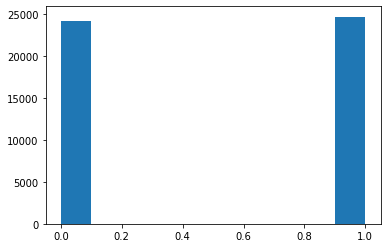

In [863]:
plt.hist(x = y_test2)

### Variable importance

Logistic regression has the nice benefit of giving us information how "important" a variable is.

Plot the top ten most important variables. Do the variables which you identified in the EDA show up? If you find variables in the list, you haven't looked at in the EDA, consider going back to the EDA task to plot them to get an intuition on why they might be important.

**Hint:** If you have used the statsmodel library for your logit model, the above task should be easy. If you developed the logit model using scikit-learn, you cannot easily get p-values for regression coefficients. See [this post for some details and remedies](https://datascience.stackexchange.com/questions/15398/how-to-get-p-value-and-confident-interval-in-logisticregression-with-sklearn). A crude but workable solution for scikit-learn users is to select important variables by looking at the magnitude of the estimated coefficients. Provided you did scale your data, which we did before, coefficient magnitudes signal variable importance. We will discuss more powerful and versatile ways to determine variable importance in the course.

In [922]:
l = zip (np.abs(logit1.coef_[0]), X_train_1.columns)

In [923]:
coefs = sorted(l, key = lambda x: x[0] )

In [924]:
coefs = coefs[-10:]
coefs

[(0.058603693625714895, 'pre_CHANNEL_TYPE_AP+ (Cash loan)'),
 (0.05979930883050809, 'app_CODE_GENDER_XNA'),
 (0.07018110745493732, 'app_OCCUPATION_TYPE_Accountants'),
 (0.07284014510708668, 'pre_NAME_CASH_LOAN_PURPOSE_Money for a third person'),
 (0.08252597835046777, 'app_NAME_INCOME_TYPE_Businessman'),
 (0.12100404785987451, 'app_NAME_INCOME_TYPE_Student'),
 (0.18265779458262982, 'app_DAYS_LAST_PHONE_CHANGE'),
 (0.24125307215759045, 'app_NAME_EDUCATION_TYPE_Higher education'),
 (0.31788831248509464, 'app_DAYS_BIRTH'),
 (0.3564277505666889, 'pre_SELLERPLACE_AREA')]

In [925]:
def calc_imp (X):
    m = X[-1][0]
    importances = []
    for i in X:
        importances.append( i[0] * 100 / m )
    return importances

In [926]:
plot_data = calc_imp(coefs)

In [927]:
l

In [937]:
for i, col in coefs:
    print(i, col)

0.058603693625714895 pre_CHANNEL_TYPE_AP+ (Cash loan)
0.05979930883050809 app_CODE_GENDER_XNA
0.07018110745493732 app_OCCUPATION_TYPE_Accountants
0.07284014510708668 pre_NAME_CASH_LOAN_PURPOSE_Money for a third person
0.08252597835046777 app_NAME_INCOME_TYPE_Businessman
0.12100404785987451 app_NAME_INCOME_TYPE_Student
0.18265779458262982 app_DAYS_LAST_PHONE_CHANGE
0.24125307215759045 app_NAME_EDUCATION_TYPE_Higher education
0.31788831248509464 app_DAYS_BIRTH
0.3564277505666889 pre_SELLERPLACE_AREA


In [944]:
y = [col for _, col in coefs]
x = [i for i,_ in coefs]
df = pd.DataFrame( {'X_axes' : x, 'Y_axes' : y} )

In [946]:
df

,X_axes,Y_axes
0,0.058604,pre_CHANNEL_TYPE_AP+ (Cash loan)
1,0.059799,app_CODE_GENDER_XNA
2,0.070181,app_OCCUPATION_TYPE_Accountants
3,0.072840,pre_NAME_CASH_LOAN_PURPOSE_Money for a third p...
4,0.082526,app_NAME_INCOME_TYPE_Businessman
5,0.121004,app_NAME_INCOME_TYPE_Student
6,0.182658,app_DAYS_LAST_PHONE_CHANGE
7,0.241253,app_NAME_EDUCATION_TYPE_Higher education
8,0.317888,app_DAYS_BIRTH
9,0.356428,pre_SELLERPLACE_AREA


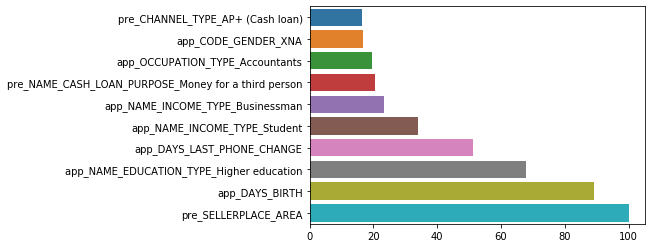

In [956]:
sns.barplot(y = y, x = plot_data)

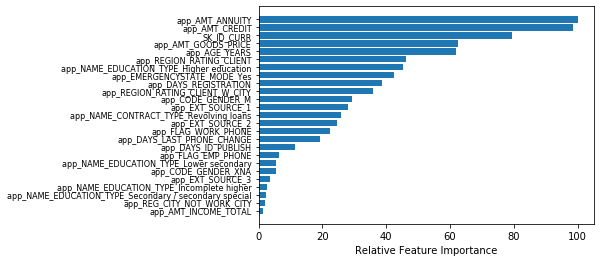

In [0]:
# Code to visualize variable importance

## The next steps: 
Given that this is a kaggle competition you can actually submit your prediction on the test dataset to the kaggle leaderboard and see how well you perform. Do not be too disappointed if not achieving a high place in the leaderboard ;)

Feel free to further tweak your model by, for example, exploring other datasets of the competition, engineering new variables, etc. We will continue working with the data in the course and learn about various options to create a good  classification model.